In [44]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

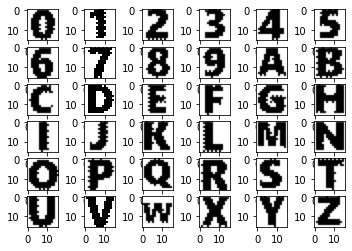

In [45]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet1/' + chr(f(i)) + str(1) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [46]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.ReLU()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(d_hidden[2], d_hidden[3])
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(d_hidden[3],num_classes)
        self.activate4 = nn.Sigmoid()

        
    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        res = self.linear4(res)
        res = self.activate4(res)
        return res

In [47]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [48]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 36, 256, 256
d_hidden=[320, 320, 320, 320]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models1'):
    os.mkdir('./models1')
torch.save(model, './models1/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models1/' + str(i) + '/'):
        os.mkdir('./models1/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [49]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2503 MAE: 0.5002 Mean Error: 0.0751 STD: 0.4946
[10/600] Loss: 0.1774 MAE: 0.2978 Mean Error: 0.0196 STD: 0.4208
[20/600] Loss: 0.1566 MAE: 0.3141 Mean Error: -0.0109 STD: 0.3957
[30/600] Loss: 0.1290 MAE: 0.2577 Mean Error: -0.0020 STD: 0.3592
[40/600] Loss: 0.1137 MAE: 0.2313 Mean Error: -0.0060 STD: 0.3371
[50/600] Loss: 0.1020 MAE: 0.2012 Mean Error: -0.0027 STD: 0.3193
[60/600] Loss: 0.0938 MAE: 0.1890 Mean Error: 0.0074 STD: 0.3062
[70/600] Loss: 0.0821 MAE: 0.1707 Mean Error: -0.0034 STD: 0.2866
[80/600] Loss: 0.0672 MAE: 0.1396 Mean Error: 0.0019 STD: 0.2593
[90/600] Loss: 0.0541 MAE: 0.1106 Mean Error: -0.0068 STD: 0.2326
[100/600] Loss: 0.0418 MAE: 0.0857 Mean Error: -0.0030 STD: 0.2045
[110/600] Loss: 0.0332 MAE: 0.0657 Mean Error: -0.0009 STD: 0.1822
[120/600] Loss: 0.0270 MAE: 0.0514 Mean Error: -0.0027 STD: 0.1642
[130/600] Loss: 0.0229 MAE: 0.0412 Mean Error: -0.0002 STD: 0.1513
[140/600] Loss: 0.0204 MAE: 0.0340 Mean Error: -0.0009 STD: 0.1427
[150/600] 

(36, 256)


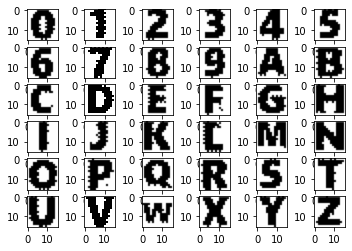

In [50]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass1output'):
    os.mkdir('./ass1output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset1 = np.zeros([36, 256])
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(img)
    output_path = './ass1output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset1[i] = array


(36, 256)


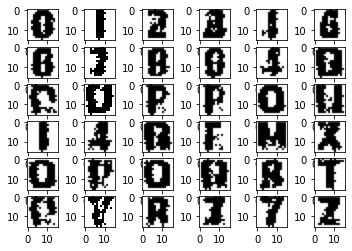

In [51]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     plt.subplot(6,6,i+1)
#     plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output'):
    os.mkdir('./ass2output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset2 = np.zeros([36, 256])
output_dataset2_model = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2_model.detach().numpy()
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(img)
    output_path2 = './ass2output/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset2[i] = array

In [52]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [53]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [54]:
Fh_array1 = calculateFh(dataSet, output_dataset1)
Ffa_array1 = calculateFfa(dataSet, output_dataset1)
Fh_array2 = calculateFh(dataSet2, output_dataset2)
Ffa_array2 = calculateFfa(dataSet2, output_dataset2)
print(Fh_array2)
print(Ffa_array2)

[0.97590361 0.97810219 0.93719807 0.92142857 0.90322581 0.90663391
 0.90593047 0.90925926 0.91242038 0.91396333 0.88279302 0.88482239
 0.88007929 0.87787611 0.86486486 0.85954198 0.8623137  0.85917313
 0.85980149 0.85883048 0.8600551  0.85427666 0.85044423 0.84322034
 0.84474273 0.84293641 0.84449858 0.84487427 0.84672897 0.84292436
 0.84164326 0.83987709 0.83546798 0.83487704 0.83432137 0.83602069]
[0.23121387 0.13066667 0.15686275 0.19354839 0.171459   0.18246236
 0.19109747 0.18700265 0.18436754 0.18368449 0.18023833 0.18665422
 0.19318672 0.19600652 0.19816724 0.1959799  0.19979613 0.19901961
 0.1903444  0.18967027 0.19460826 0.19127876 0.1957535  0.19825871
 0.19951981 0.19846974 0.1982468  0.20139647 0.2029901  0.19991865
 0.20184748 0.20026601 0.20136961 0.20114839 0.20034752 0.19919042]


36
36


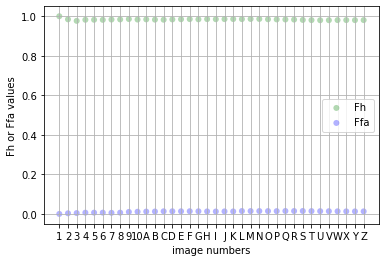

In [55]:
# TODO: Step 4c: Answer 2 questions from canvas
# Q1 Yes there is mismatch
# Q2 Should we compare Dataset2 output vs Dataset1 input? 50-50
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)

# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# Graph for dataset1
import numpy as np
import matplotlib.pyplot as plt

std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

Image_name = ['1','2','3','4','5','6','7','8','9','10','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
print(len(Image_name))
print(len(Ffa_array))
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array1, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array1, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()


36
36


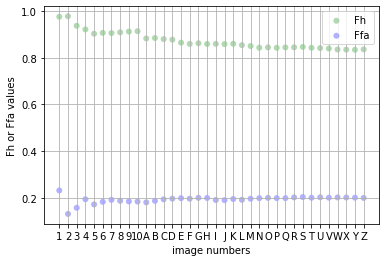

In [56]:
# Graph for dataset2
std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

Image_name = ['1','2','3','4','5','6','7','8','9','10','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
print(len(Image_name))
print(len(Ffa_array))
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array2, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array2, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()

In [59]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
    print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*256))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*256))
    for i in range(int(percentage*256)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 36, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise2/'):
        os.mkdir('./input_noise2/')
for k in range(5):
    if not os.path.exists('./input_noise2/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise2/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise2/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(36):
            inputImage = dataSet2[i].copy()
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array = np.zeros([5, 9, 36])
Ffa_noise_array = np.zeros([5, 9, 36])

# Train 9 datasets with noise
if not os.path.exists('./output_noise2/'):
        os.mkdir('./output_noise2/')
for k in range(5):
    if not os.path.exists('./output_noise2/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise2/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models2/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models2/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([36, 256])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise2/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(36):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    #Fh = calculateFh(dataSet, output_noise_dataset)
    #Ffa = calculateFfa(dataSet, output_noise_dataset)
    #Fh_noise_array[j] = Fh
    #Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1.19133371 1.34782404 1.08741084 1.06829596 1.35263044 1.39042119
 1.49283988 1.11433112 1.13026204 1.13000742 0.98094431 1.21185932
 1.49122933 1.01174709 1.39314224 1.22951539 1.05573456 1.10840244
 1.17095285 1.19693023 1.14745493 1.24867202 0.22167601 1.21143539
 0.39725451 1.10712864 1.22550911 1.36640138 1.04561033 1.00294022
 1.08874514 1.47037241 1.15644551 1.09888567 1.46449269 1.08577196
 0.23627451 0.27516549 1.11355023 1.24090713 1.17338131 0.42704556
 0.16960934 1.09285093 1.38705948 1.20050684 1.19025249 1.61153155
 1.11967263 1.08119726 1.05647146 1.05690481 0.37184817 0.35548249
 1.05922488 1.07220071 1.41665829 0.14274965 0.0820298  0.23436044
 1.09975193 1.24733824 1.01493331 1.20532643 1.16113289 1.06269565
 1.14109469 0.14836417 0.61377707 0.19086655 1.10103507 1.148223
 1.1953324  0.33038526 0.31159311 0.0805836  1.11647561 1.07174591
 1.12908736 1.13335105 1.2419731  1.25120982 1.14745326 0.13304903
 0.00718723 0.14440583 1.21379499 1.07067162 1.16114856 0.193437

[1.05257861 1.17087923 1.21005818 1.11130288 1.27512225 1.21992891
 1.01941437 1.15635674 1.25194087 1.13433181 1.13082139 1.16844592
 1.0084945  1.21142289 1.07894809 1.23039657 1.09409027 1.13097386
 1.06392778 0.19232737 0.08413142 1.14636204 0.17075377 0.16322715
 1.38121512 1.15141395 0.07771258 1.4977233  1.26370567 1.22888706
 1.02162104 1.13520516 1.05946289 1.32468365 0.19966114 0.16733753
 0.20629862 0.31456742 0.38478967 0.14912338 1.05389389 0.42642661
 0.13318913 0.38344312 0.23712956 0.30748783 1.13556209 1.12215454
 1.18754629 1.18770879 1.08409227 1.06799415 0.44313189 0.05331375
 0.09966483 0.09396929 1.17375085 1.30824553 1.37833092 0.08899351
 0.30254096 0.04657101 0.20591603 1.07007892 1.08273254 1.27241744
 1.30157987 0.07760363 0.40220708 0.10326529 0.312185   0.15894468
 0.9893831  1.07300188 0.21342879 0.16029659 0.1935116  0.10574938
 0.08733011 1.12638816 1.47479855 1.33963485 1.14815953 0.40917897
 0.09252482 0.08928641 0.24886498 0.21007322 1.26952959 1.1962

[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.10437406 0.36286294 0.12037669 1.13554367 1.10887

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.13200378 1.02252582 1.09315341 1.21605225 1.16749356

 1.37580501 1.17036946 1.72384727 1.        ]
[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.104

 1.25486375 1.02108985 1.05136831 1.        ]
[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.121

[1.22978988 1.32431474 1.36079278 1.4044377  1.27924261 1.04412264
 1.31548757 1.15213018 1.15909259 1.21423678 1.21076161 1.02782672
 1.05451116 1.01618664 1.13386433 1.10107196 1.09873377 1.21817925
 1.23533131 1.24598423 1.089171   1.16993212 0.18523815 0.17716261
 0.1842747  0.93545717 1.23364922 1.04611734 1.41550618 1.11056901
 1.0830698  1.08206751 1.42875736 1.19863057 1.52558282 1.14674072
 1.54823577 1.28526147 0.27374302 0.23025532 0.22150179 0.48940288
 1.41368325 1.24919293 1.11035467 1.02493697 1.55569631 1.04634003
 1.08254251 1.20199007 1.20393371 1.26071347 1.47405    1.18310219
 1.02890874 0.17416298 0.20868802 0.09125327 1.10297318 1.07989736
 1.14820318 1.16676044 1.41032843 1.54828289 1.08574772 1.04541743
 1.26208571 1.03095985 1.16046252 1.23013787 0.16680822 0.2546468
 0.28563862 0.08285157 1.14328221 1.16604343 1.36748615 1.23239424
 1.00805298 1.17652142 1.06261125 1.09730685 1.15537145 1.25704595
 1.22115625 1.11112538 0.99215455 0.59481643 0.59008296 0.06195

[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45711879 0.29996548 1.02861424 1.24988838 1.1602

[1.04567341 1.32086294 1.02302403 1.15577412 1.13721663 1.18894953
 1.04729138 0.96441675 1.15844348 1.13460711 1.11100698 1.05463783
 1.05614493 1.37610229 1.06849161 1.2915016  1.30239754 0.20502876
 1.21781263 0.82357014 1.03651129 0.17021936 1.32892857 1.01921706
 1.03999408 0.11914583 1.4485325  0.22589363 1.20687038 0.05283198
 1.06138797 1.21917344 1.1266808  0.14203585 0.20606064 0.15277907
 0.47369822 0.24802688 0.35310967 1.03829889 1.10323938 0.06536791
 0.21104274 0.33368608 0.07798511 0.19508511 0.54320547 1.0281632
 1.29605695 0.08642986 0.06406073 0.03834532 0.07180637 0.09707578
 1.07853407 1.18528662 1.21631879 0.10845888 0.11388731 0.18980988
 0.38304215 0.14187358 1.02874842 1.02679415 1.04694256 1.48321709
 0.11240494 0.08772505 0.02680113 0.2792957  1.06427991 1.01136347
 1.24722294 1.02046489 0.28212719 0.13512713 0.16619405 0.13144
 1.21726042 1.09045833 1.08402578 0.37822317 0.49603794 0.26591314
 0.1859201  0.1780485  1.44427038 1.22132235 1.06727582 0.07539343

[1.07062867 1.1171627  1.01128963 1.37053162 1.07119605 1.2954531
 1.31004586 1.15468901 1.17906823 1.13550353 1.08543475 1.27614682
 1.31546595 1.13995679 1.15036737 1.41508722 1.06321596 1.30967872
 0.08475438 1.43675004 0.06498556 1.14918154 0.15282396 1.09163518
 0.08103362 1.23152372 1.2639529  0.0713119  1.19612729 1.08172435
 1.02687374 1.05989619 1.03649284 1.08364219 0.20281924 0.22617071
 0.34396236 0.19232866 0.17239151 1.18510233 1.16589518 0.24459515
 0.10971606 0.1965679  0.03790981 1.10427284 1.16751811 0.91810289
 1.1023704  1.06913991 0.24732504 0.19537612 0.04432344 0.0252433
 0.21817773 1.18074079 1.30948673 0.09146789 0.24764053 0.22236302
 0.146238   0.33033013 1.16175925 1.15655958 1.09767767 1.164786
 0.05483096 0.55322962 0.12258549 0.5084039  0.34047585 1.22181632
 1.30874127 1.31090021 0.17308601 0.35023158 0.09580184 0.10919179
 1.13719927 1.22911611 1.16237612 1.21428493 0.17514548 0.14776266
 0.08067592 0.22721937 0.17473857 1.35806626 1.15652457 0.31874965

 1.07069289 1.13060452 1.27068779 1.        ]
[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.251

[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.13200378 1.02252582 1.09315341 1.21605225 1.16749356

[1.45989735 1.15319138 1.17608024 1.0696567  1.35328617 1.27143755
 1.17047335 1.02194854 1.15736832 1.30929352 1.07779316 1.33852444
 1.27154176 1.20607011 1.4814169  1.06177965 1.20337989 1.23190026
 1.04095673 1.19035375 1.14814757 1.13848257 0.20435582 1.21988477
 1.08699006 0.15843409 1.40679098 1.16069753 0.10822145 1.09153274
 1.34291284 1.06450509 1.09677249 1.12153398 1.28188303 1.26803323
 0.25357149 0.49591968 0.41891665 1.20426564 1.02736976 0.12729315
 0.36789963 0.10134863 0.24386348 1.16152472 1.11665788 1.26308961
 1.03612593 1.04013071 1.14654519 0.21481224 0.06154333 0.33159038
 1.38749561 1.02138646 1.07103633 1.09877861 1.15610848 0.06857088
 0.14074783 1.13357514 1.02928196 1.18190965 1.1147867  1.07823105
 1.29801291 0.24656881 0.25971887 0.17427448 0.37026438 1.30090795
 1.17296044 1.00165174 1.06278704 1.32373345 0.30879399 1.15787155
 1.12058102 1.48695373 1.25467948 1.06924335 0.39972503 0.17185971
 0.20616833 0.05157298 0.06820915 1.16605619 1.18745021 1.1945

 1.08983664 1.13132653 1.06828241 1.        ]
[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45

[1.21601819 1.13444747 1.06552536 1.14900042 1.06395274 1.23779262
 1.2217252  1.15748005 1.2908557  1.39960421 1.07300814 1.09563764
 1.16528553 1.07423683 1.24985384 1.04445601 0.18161846 1.02225903
 0.43054569 0.06752226 0.17891037 1.14266725 1.12146841 1.33000082
 1.21269365 1.04547628 0.03833427 1.25448011 0.39573343 0.1319916
 0.38508779 1.2576994  1.19585578 0.37751257 0.40139374 0.1164868
 0.04597779 0.15461507 0.31831538 1.21816133 1.32458716 1.37888465
 0.34576112 0.13274831 0.08000975 0.28775371 0.32756107 1.11920355
 1.0179857  1.489406   0.2748713  0.10667116 0.26262346 0.12235814
 0.15260543 1.41188794 1.19879613 1.21013605 0.31922531 0.15169852
 0.3193472  0.2217932  0.11859498 1.12950817 1.10287171 1.44241107
 0.31103225 0.00714795 0.39175984 0.07897447 0.19292032 1.07181131
 1.13695515 1.46176699 0.34919901 0.22463324 0.02732077 0.18224943
 0.17672609 1.04886241 1.19632407 1.21834585 1.16278522 0.2361009
 0.28338099 0.11069819 0.18434478 0.06740018 1.31553474 1.3169855

[1.07062867 1.1171627  1.01128963 1.37053162 1.07119605 1.2954531
 1.31004586 1.15468901 1.17906823 1.13550353 1.08543475 1.27614682
 1.31546595 1.13995679 1.15036737 1.41508722 1.06321596 1.30967872
 0.08475438 1.43675004 0.06498556 1.14918154 0.15282396 1.09163518
 0.08103362 1.23152372 1.2639529  0.0713119  1.19612729 1.08172435
 1.02687374 1.05989619 1.03649284 1.08364219 0.20281924 0.22617071
 0.34396236 0.19232866 0.17239151 1.18510233 1.16589518 0.24459515
 0.10971606 0.1965679  0.03790981 1.10427284 1.16751811 0.91810289
 1.1023704  1.06913991 0.24732504 0.19537612 0.04432344 0.0252433
 0.21817773 1.18074079 1.30948673 0.09146789 0.24764053 0.22236302
 0.146238   0.33033013 1.16175925 1.15655958 1.09767767 1.164786
 0.05483096 0.55322962 0.12258549 0.5084039  0.34047585 1.22181632
 1.30874127 1.31090021 0.17308601 0.35023158 0.09580184 0.10919179
 1.13719927 1.22911611 1.16237612 1.21428493 0.17514548 0.14776266
 0.08067592 0.22721937 0.17473857 1.35806626 1.15652457 0.31874965

[1.22978988 1.32431474 1.36079278 1.4044377  1.27924261 1.04412264
 1.31548757 1.15213018 1.15909259 1.21423678 1.21076161 1.02782672
 1.05451116 1.01618664 1.13386433 1.10107196 1.09873377 1.21817925
 1.23533131 1.24598423 1.089171   1.16993212 0.18523815 0.17716261
 0.1842747  0.93545717 1.23364922 1.04611734 1.41550618 1.11056901
 1.0830698  1.08206751 1.42875736 1.19863057 1.52558282 1.14674072
 1.54823577 1.28526147 0.27374302 0.23025532 0.22150179 0.48940288
 1.41368325 1.24919293 1.11035467 1.02493697 1.55569631 1.04634003
 1.08254251 1.20199007 1.20393371 1.26071347 1.47405    1.18310219
 1.02890874 0.17416298 0.20868802 0.09125327 1.10297318 1.07989736
 1.14820318 1.16676044 1.41032843 1.54828289 1.08574772 1.04541743
 1.26208571 1.03095985 1.16046252 1.23013787 0.16680822 0.2546468
 0.28563862 0.08285157 1.14328221 1.16604343 1.36748615 1.23239424
 1.00805298 1.17652142 1.06261125 1.09730685 1.15537145 1.25704595
 1.22115625 1.11112538 0.99215455 0.59481643 0.59008296 0.06195

 1.1595078  1.42042598 1.12426468 1.        ]
[1.242307   1.01619157 1.06292311 1.0909443  1.27112589 1.54661195
 1.27269421 1.09013085 1.27483685 1.0671976  1.49398137 1.22947459
 1.21055366 1.06414988 1.13240063 1.07572983 1.18888154 0.91204361
 1.00600929 1.32960743 1.07928774 1.09177425 1.23903971 1.0907828
 0.08058078 0.42742313 1.06002315 1.21756154 1.56221911 1.32480167
 1.21701659 1.22296563 1.19816825 1.33449397 1.17437745 1.03855569
 1.09831595 1.21695241 1.04300231 0.28242762 0.14366063 0.52115068
 1.36044504 1.17544751 1.11337724 1.14339328 1.15185513 1.13688565
 1.25528666 1.00248467 1.12199197 1.05220862 1.16078058 1.07639729
 1.10190526 0.07449263 0.14312942 0.11392684 1.06737003 1.29576354
 1.26969341 1.14781025 1.27746606 1.09206539 1.07410064 1.14250902
 1.25790728 1.22913244 1.26203636 1.26205082 0.24314644 0.25989261
 0.23389034 0.15072288 1.02662197 1.06376658 1.13362886 1.26463056
 0.92787141 1.17500344 1.14593784 1.17263606 1.35312598 1.02927319
 1.26639741 1.209

[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45869807 0.01629793 0.24732434 1.17343547 1.5795

[1.07062867 1.1171627  1.01128963 1.37053162 1.07119605 1.2954531
 1.31004586 1.15468901 1.17906823 1.13550353 1.08543475 1.27614682
 1.31546595 1.13995679 1.15036737 1.41508722 1.06321596 1.30967872
 0.08475438 1.43675004 0.06498556 1.14918154 0.15282396 1.09163518
 0.08103362 1.23152372 1.2639529  0.0713119  1.19612729 1.08172435
 1.02687374 1.05989619 1.03649284 1.08364219 0.20281924 0.22617071
 0.34396236 0.19232866 0.17239151 1.18510233 1.16589518 0.24459515
 0.10971606 0.1965679  0.03790981 1.10427284 1.16751811 0.91810289
 1.1023704  1.06913991 0.24732504 0.19537612 0.04432344 0.0252433
 0.21817773 1.18074079 1.30948673 0.09146789 0.24764053 0.22236302
 0.146238   0.33033013 1.16175925 1.15655958 1.09767767 1.164786
 0.05483096 0.55322962 0.12258549 0.5084039  0.34047585 1.22181632
 1.30874127 1.31090021 0.17308601 0.35023158 0.09580184 0.10919179
 1.13719927 1.22911611 1.16237612 1.21428493 0.17514548 0.14776266
 0.08067592 0.22721937 0.17473857 1.35806626 1.15652457 0.31874965

[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.10437406 0.36286294 0.12037669 1.13554367 1.10887

[1.13493213 1.28497422 1.24356489 1.2262931  1.02392889 1.23436991
 1.12913293 1.40530458 1.12741546 1.03702515 1.35709098 1.11793292
 1.16708864 1.20605093 1.06715144 1.07845919 1.19674611 1.37840481
 1.05991713 1.28486787 1.20460051 0.44648524 0.08780765 1.04585262
 0.04713566 0.15759073 0.15591947 1.35620518 1.30458427 1.24949102
 1.13248781 1.18940413 1.04169595 1.26514657 1.28746766 1.07964299
 0.08741937 0.22419092 1.12807888 1.25211513 1.29980893 0.48301391
 0.09959755 0.12972803 1.2447258  1.31399259 1.17240165 1.10917592
 1.11429831 1.12027998 1.08900772 1.45615385 0.22027896 0.24890183
 0.14298518 0.11884174 1.25474404 0.177108   0.07415154 0.09209185
 0.17778499 1.09267349 1.06327904 1.56812642 1.07982216 1.19980111
 1.05877095 1.34807512 0.06559169 0.10975317 0.20586348 1.15669074
 1.18074874 0.38480778 0.06837445 0.02943499 0.20252152 1.2054499
 1.36927652 1.07874479 1.10332689 1.0196554  1.22891058 1.26955433
 0.17520612 0.07419778 0.07620556 1.21356388 1.29978148 0.27614

[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03996845 0.2069402  0.29137652 1.13020537 1.1560

[1.45989735 1.15319138 1.17608024 1.0696567  1.35328617 1.27143755
 1.17047335 1.02194854 1.15736832 1.30929352 1.07779316 1.33852444
 1.27154176 1.20607011 1.4814169  1.06177965 1.20337989 1.23190026
 1.04095673 1.19035375 1.14814757 1.13848257 0.20435582 1.21988477
 1.08699006 0.15843409 1.40679098 1.16069753 0.10822145 1.09153274
 1.34291284 1.06450509 1.09677249 1.12153398 1.28188303 1.26803323
 0.25357149 0.49591968 0.41891665 1.20426564 1.02736976 0.12729315
 0.36789963 0.10134863 0.24386348 1.16152472 1.11665788 1.26308961
 1.03612593 1.04013071 1.14654519 0.21481224 0.06154333 0.33159038
 1.38749561 1.02138646 1.07103633 1.09877861 1.15610848 0.06857088
 0.14074783 1.13357514 1.02928196 1.18190965 1.1147867  1.07823105
 1.29801291 0.24656881 0.25971887 0.17427448 0.37026438 1.30090795
 1.17296044 1.00165174 1.06278704 1.32373345 0.30879399 1.15787155
 1.12058102 1.48695373 1.25467948 1.06924335 0.39972503 0.17185971
 0.20616833 0.05157298 0.06820915 1.16605619 1.18745021 1.1945

 1.1595078  1.42042598 1.12426468 1.        ]
[1.242307   1.01619157 1.06292311 1.0909443  1.27112589 1.54661195
 1.27269421 1.09013085 1.27483685 1.0671976  1.49398137 1.22947459
 1.21055366 1.06414988 1.13240063 1.07572983 1.18888154 0.91204361
 1.00600929 1.32960743 1.07928774 1.09177425 1.23903971 1.0907828
 0.08058078 0.42742313 1.06002315 1.21756154 1.56221911 1.32480167
 1.21701659 1.22296563 1.19816825 1.33449397 1.17437745 1.03855569
 1.09831595 1.21695241 1.04300231 0.28242762 0.14366063 0.52115068
 1.36044504 1.17544751 1.11337724 1.14339328 1.15185513 1.13688565
 1.25528666 1.00248467 1.12199197 1.05220862 1.16078058 1.07639729
 1.10190526 0.07449263 0.14312942 0.11392684 1.06737003 1.29576354
 1.26969341 1.14781025 1.27746606 1.09206539 1.07410064 1.14250902
 1.25790728 1.22913244 1.26203636 1.26205082 0.24314644 0.25989261
 0.23389034 0.15072288 1.02662197 1.06376658 1.13362886 1.26463056
 0.92787141 1.17500344 1.14593784 1.17263606 1.35312598 1.02927319
 1.26639741 1.209

[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.10437406 0.36286294 0.12037669 1.13554367 1.10887

[1.04567341 1.32086294 1.02302403 1.15577412 1.13721663 1.18894953
 1.04729138 0.96441675 1.15844348 1.13460711 1.11100698 1.05463783
 1.05614493 1.37610229 1.06849161 1.2915016  1.30239754 0.20502876
 1.21781263 0.82357014 1.03651129 0.17021936 1.32892857 1.01921706
 1.03999408 0.11914583 1.4485325  0.22589363 1.20687038 0.05283198
 1.06138797 1.21917344 1.1266808  0.14203585 0.20606064 0.15277907
 0.47369822 0.24802688 0.35310967 1.03829889 1.10323938 0.06536791
 0.21104274 0.33368608 0.07798511 0.19508511 0.54320547 1.0281632
 1.29605695 0.08642986 0.06406073 0.03834532 0.07180637 0.09707578
 1.07853407 1.18528662 1.21631879 0.10845888 0.11388731 0.18980988
 0.38304215 0.14187358 1.02874842 1.02679415 1.04694256 1.48321709
 0.11240494 0.08772505 0.02680113 0.2792957  1.06427991 1.01136347
 1.24722294 1.02046489 0.28212719 0.13512713 0.16619405 0.13144
 1.21726042 1.09045833 1.08402578 0.37822317 0.49603794 0.26591314
 0.1859201  0.1780485  1.44427038 1.22132235 1.06727582 0.07539343

[1.0174916  1.05266289 1.26750574 1.01970401 1.23446729 0.98480718
 1.34865631 1.22904005 1.12082115 1.29472047 0.9864702  1.06495041
 1.33040985 1.36685152 1.08508064 1.33045487 1.19788882 1.17883262
 1.29951526 0.30616142 1.03914515 1.45579143 0.3628794  1.21560863
 0.14785724 1.09040327 1.297101   1.17027449 0.42314965 1.08154039
 1.14436123 1.29140856 1.07511832 1.08882357 0.14529523 0.1197506
 0.20172201 1.06514215 0.21797621 0.03195811 0.30816688 0.19935369
 0.123127   1.05419105 0.29266363 0.14597506 0.02128988 1.17486451
 1.10987203 1.31899065 0.21026051 0.16645826 1.13932774 1.13071747
 0.21054971 0.35094342 0.02245697 0.10804233 1.19392519 1.17424015
 0.03484304 0.13468419 1.3772504  1.05733919 1.22992096 0.22748983
 0.0349494  1.24373424 1.12152714 1.06061168 0.31033692 0.07860527
 0.27909991 0.1728204  0.10474905 1.29123561 1.23310471 0.16386021
 1.32034608 1.07247285 1.19524026 1.33254811 1.10554336 1.23724143
 1.04458089 0.28469585 0.08172532 0.59778157 0.18577231 0.07357

 1.18501621 1.27293584 1.1289496  1.        ]
[1.19133371 1.34782404 1.08741084 1.06829596 1.35263044 1.39042119
 1.49283988 1.11433112 1.13026204 1.13000742 0.98094431 1.21185932
 1.49122933 1.01174709 1.39314224 1.22951539 1.05573456 1.10840244
 1.17095285 1.19693023 1.14745493 1.24867202 0.22167601 1.21143539
 0.39725451 1.10712864 1.22550911 1.36640138 1.04561033 1.00294022
 1.08874514 1.47037241 1.15644551 1.09888567 1.46449269 1.08577196
 0.23627451 0.27516549 1.11355023 1.24090713 1.17338131 0.42704556
 0.16960934 1.09285093 1.38705948 1.20050684 1.19025249 1.61153155
 1.11967263 1.08119726 1.05647146 1.05690481 0.37184817 0.35548249
 1.05922488 1.07220071 1.41665829 0.14274965 0.0820298  0.23436044
 1.09975193 1.24733824 1.01493331 1.20532643 1.16113289 1.06269565
 1.14109469 0.14836417 0.61377707 0.19086655 1.10103507 1.148223
 1.1953324  0.33038526 0.31159311 0.0805836  1.11647561 1.07174591
 1.12908736 1.13335105 1.2419731  1.25120982 1.14745326 0.13304903
 0.00718723 0.1444

 1.08518128 1.34888387 1.1063585  1.        ]
[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45

[1.29452853 1.18978158 1.41423526 1.45749725 1.13711557 1.12981765
 1.1213233  1.16088269 1.28733844 1.29274876 1.2112192  1.03691205
 1.06466867 1.21843893 1.3794803  1.13900117 1.10470933 1.30392765
 0.0760681  1.14112591 0.10549386 1.07530314 0.1053387  1.20714391
 1.23562322 1.0065807  1.15408858 0.24703202 1.61153641 0.27621273
 1.54141394 1.09865278 1.128877   0.16269778 0.57142662 0.07796573
 0.08970535 0.06321912 0.04089258 1.16522544 1.43806558 1.20835598
 1.11143579 0.2006451  0.06328026 0.11515299 1.0453472  1.02365092
 1.05389539 1.25236215 0.05495014 0.31312062 0.08833047 0.15691595
 0.10177704 1.18842076 1.25073965 1.2069228  1.22564578 1.07501339
 0.26647611 1.18940196 1.13392275 1.16212647 1.33339892 1.03555987
 0.18299048 0.4962683  0.23308671 0.12133642 1.25508644 1.13541725
 1.13000057 1.11033701 1.20002902 1.36304226 0.18116979 1.1498307
 1.01791299 1.20169325 1.15042915 1.15628393 0.17213753 0.37622082
 0.22332491 0.24185247 0.13293854 1.00302873 1.11851111 1.12402

[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45711879 0.29996548 1.02861424 1.24988838 1.1602

[1.14269822 1.29140188 1.26072169 1.2182854  1.1257331  1.08328743
 1.40367746 1.26196466 1.29573106 1.17502353 1.09039162 1.24456802
 1.15735631 1.2841791  0.92067622 1.10669838 0.22895449 0.12897977
 0.15243589 0.18449647 0.15542218 0.36186387 1.46971679 1.07156738
 0.16325106 0.40245124 1.49619749 1.02887798 0.20129753 0.33784409
 0.1425194  0.07928535 0.12711403 0.11964471 0.33389151 0.13794087
 0.23955937 1.23922866 1.41991691 1.35147156 0.10373263 0.04066197
 1.32356849 1.35503479 1.1608636  0.35825366 1.27658164 1.14937889
 1.16498712 0.20135491 0.34330426 0.37439123 0.28389061 1.15992377
 1.17750775 0.07738353 0.0337676  0.27594361 0.39333092 1.55182373
 1.02951557 0.33243852 1.07817695 1.0900878  1.08811506 0.22551907
 0.35994277 0.11328974 0.20448705 0.26606865 1.12323967 1.15123893
 0.05263241 0.09640785 0.37456016 1.02922349 1.08279202 0.28077457
 1.34505774 1.15403207 1.26187396 0.15723773 0.13920614 0.15018893
 0.17600945 1.14328046 1.19273281 0.13244609 0.33077702 0.0416

[1.10907393 1.1393159  1.24770597 1.12764815 1.17906164 1.06420539
 1.01688256 1.30812756 1.07950789 1.19737496 1.32761133 1.38312287
 1.15944489 1.05791924 1.15257104 1.07305556 1.1552823  1.14464296
 1.07960192 1.12664608 1.18887115 1.16248627 0.14706987 0.10453205
 1.34005425 0.10644474 0.2065725  1.15533395 1.09001361 1.19740535
 1.22247335 1.09024907 1.29269171 0.92345882 1.17190142 1.27030954
 1.13508067 1.13409661 0.25888136 0.09373386 0.39272525 0.25912389
 0.10604965 1.10594364 1.24715377 1.19740742 1.08344816 1.09556011
 1.05060193 1.21386617 1.10872215 1.08434811 1.29328943 1.17541961
 0.23869008 0.25417978 0.53408739 0.18004643 0.17727336 1.12035737
 1.12978354 1.02799668 1.18350947 1.05669849 1.02188676 1.19625201
 1.16191422 1.2452609  1.41001315 1.24499289 0.12201448 0.18777691
 0.13664545 0.10200203 1.13466344 1.42578787 1.08878101 1.42754319
 1.05387158 1.14974458 1.04913583 1.0790507  1.13051211 1.68003837
 1.54702943 1.2127876  1.01888191 0.14959728 0.10226203 0.3034

 1.16022241 1.35933368 1.30766753 1.        ]
[1.49062646 1.09968629 1.03849012 1.13584264 1.28965074 1.18622206
 1.22715309 1.09552566 1.08411504 1.12078102 1.13679192 1.3015628
 1.20271634 1.14048374 1.2642793  1.1810109  1.067715   1.10247364
 0.16477772 1.31010939 0.39190607 1.23333683 0.06936655 1.35606605
 1.22589416 1.0432713  1.22104833 0.5348609  1.18267131 0.1385841
 1.1036195  1.14026416 1.19096069 0.02087715 0.18193664 0.36878512
 0.10396119 0.10924413 0.26518132 0.16166889 1.11549603 1.19957358
 0.0748422  0.17182267 0.07196308 0.25668898 1.31024959 1.14428991
 1.0757136  1.14165911 0.10138589 0.26633158 0.27954125 0.3968199
 0.15349197 0.99473066 1.13520832 1.13622006 1.33372443 1.35368287
 0.50496424 1.09535982 1.17250912 1.53456633 1.04541038 1.23090617
 1.15399859 0.1782426  0.14474466 0.27183316 0.12596221 0.24554038
 1.50736696 1.56043902 1.29119224 0.4418885  1.12651101 1.27632347
 1.1870832  1.08514604 1.29139038 1.0645242  1.77570383 0.36314479
 0.10490819 0.55072

 1.12097702 1.13566621 1.18405215 1.        ]
[1.13278393 1.19902518 1.15278737 1.29010028 1.2803089  1.03573648
 1.1039126  1.24326987 1.47986816 1.24831828 1.27238303 1.1142766
 1.14100857 1.15809086 1.25758868 1.19397687 1.02687868 1.1015297
 1.10778125 1.04344845 1.09723522 0.21245951 0.31780955 1.36866619
 0.37405881 1.11447899 1.33528212 1.31694011 1.33151348 1.36622255
 1.50848606 1.1776668  1.19421754 1.07666323 1.37849046 1.05998173
 0.55974958 0.41611409 1.24629662 1.25232934 1.40997102 0.05829785
 0.0709221  1.28965487 1.64773906 1.16386781 1.13062372 1.00313756
 1.18814653 1.26713904 1.22114048 0.27412944 0.17383718 0.29467604
 1.04287819 1.05229463 0.10192057 0.11154848 0.23909732 0.16616412
 1.04075995 1.07157648 1.18509092 1.06401522 1.06516128 1.07519448
 1.22163084 0.07183263 0.45919613 0.30333286 1.38072571 1.11099719
 0.08694106 0.17968312 0.0512364  1.10575028 1.14848668 1.12618757
 1.04053344 1.14046881 1.12739168 1.18656989 0.20822188 0.12479007
 0.4346101  0.2953

[1.15354043 1.33056625 1.17889057 1.18273471 1.09325993 1.0532581
 1.0440273  1.26958105 1.11807614 1.36700526 1.04075114 1.16106314
 1.01575043 1.17929207 1.33821855 1.46480261 1.19851304 1.05732985
 1.07490151 1.17477257 1.14552519 0.14724352 1.12122422 1.16878599
 0.29019314 1.22679883 0.12563339 1.0911787  1.33319153 1.09220167
 1.44691203 1.13868265 1.02420591 1.08849647 1.27164498 0.20010927
 0.28700582 0.1020204  0.15179744 1.19011255 1.02431997 0.3456323
 0.01642508 0.16595527 1.10656215 1.03756272 1.14240198 1.05701346
 1.08326913 1.1706195  1.20991846 0.30572533 0.31548632 0.22502963
 1.24724063 1.41182016 1.15312243 0.23432498 0.0933276  0.30359559
 0.08870769 1.17900347 1.21430887 1.15053666 1.73344659 1.39161734
 0.23628312 0.27837724 0.0115523  1.06957417 1.18478075 1.19774575
 1.29871905 1.23495157 0.22236514 0.04542063 0.07286765 0.11179933
 1.09419274 1.10473154 1.13499879 0.47822748 0.16069778 0.12321857
 0.1522661  0.01729504 0.03124057 1.13537424 1.11596796 0.107709

[1.25489884 1.14900981 1.15422277 1.29595089 1.11532026 1.0256614
 1.06712713 1.14070157 1.18337295 1.08080373 1.12550117 1.21073239
 1.15350701 1.06899629 1.20469316 1.27480436 1.18806316 1.1682468
 1.05258438 1.07948935 1.25097501 0.47222102 1.12565644 0.39006942
 1.03457886 0.15693669 1.16932546 1.28826583 1.42489761 1.01894841
 1.15427822 1.05111446 1.09029053 1.11450236 1.18152733 1.1120379
 0.22582831 1.16067032 1.10369104 1.23550939 0.39595118 0.14038765
 0.36967167 1.08840662 1.26411391 1.0452511  1.09731447 1.10756435
 1.09603864 1.04129739 1.15093604 0.12803812 0.38013378 0.39721756
 1.25538649 1.36251656 0.20427936 0.06382497 0.17181493 0.07564995
 1.42838188 1.11432946 1.13013985 1.01948524 1.45662668 1.41547084
 1.37924466 0.09873104 0.15013731 0.07142289 1.12277343 1.20755314
 0.14653408 0.27631398 0.11650313 0.06874884 1.09637198 1.41575847
 1.1310778  1.0668805  1.47601876 1.29351215 1.23084645 0.3280838
 0.37986635 0.0867629  1.20097884 1.06419648 1.21806041 0.24912352

 1.08518128 1.34888387 1.1063585  1.        ]
[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45

[1.05257861 1.17087923 1.21005818 1.11130288 1.27512225 1.21992891
 1.01941437 1.15635674 1.25194087 1.13433181 1.13082139 1.16844592
 1.0084945  1.21142289 1.07894809 1.23039657 1.09409027 1.13097386
 1.06392778 0.19232737 0.08413142 1.14636204 0.17075377 0.16322715
 1.38121512 1.15141395 0.07771258 1.4977233  1.26370567 1.22888706
 1.02162104 1.13520516 1.05946289 1.32468365 0.19966114 0.16733753
 0.20629862 0.31456742 0.38478967 0.14912338 1.05389389 0.42642661
 0.13318913 0.38344312 0.23712956 0.30748783 1.13556209 1.12215454
 1.18754629 1.18770879 1.08409227 1.06799415 0.44313189 0.05331375
 0.09966483 0.09396929 1.17375085 1.30824553 1.37833092 0.08899351
 0.30254096 0.04657101 0.20591603 1.07007892 1.08273254 1.27241744
 1.30157987 0.07760363 0.40220708 0.10326529 0.312185   0.15894468
 0.9893831  1.07300188 0.21342879 0.16029659 0.1935116  0.10574938
 0.08733011 1.12638816 1.47479855 1.33963485 1.14815953 0.40917897
 0.09252482 0.08928641 0.24886498 0.21007322 1.26952959 1.1962

 1.21604772 1.03669987 1.05217993 1.        ]
[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.017098

 1.37580501 1.17036946 1.72384727 1.        ]
[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.104

[1.22978988 1.32431474 1.36079278 1.4044377  1.27924261 1.04412264
 1.31548757 1.15213018 1.15909259 1.21423678 1.21076161 1.02782672
 1.05451116 1.01618664 1.13386433 1.10107196 1.09873377 1.21817925
 1.23533131 1.24598423 1.089171   1.16993212 0.18523815 0.17716261
 0.1842747  0.93545717 1.23364922 1.04611734 1.41550618 1.11056901
 1.0830698  1.08206751 1.42875736 1.19863057 1.52558282 1.14674072
 1.54823577 1.28526147 0.27374302 0.23025532 0.22150179 0.48940288
 1.41368325 1.24919293 1.11035467 1.02493697 1.55569631 1.04634003
 1.08254251 1.20199007 1.20393371 1.26071347 1.47405    1.18310219
 1.02890874 0.17416298 0.20868802 0.09125327 1.10297318 1.07989736
 1.14820318 1.16676044 1.41032843 1.54828289 1.08574772 1.04541743
 1.26208571 1.03095985 1.16046252 1.23013787 0.16680822 0.2546468
 0.28563862 0.08285157 1.14328221 1.16604343 1.36748615 1.23239424
 1.00805298 1.17652142 1.06261125 1.09730685 1.15537145 1.25704595
 1.22115625 1.11112538 0.99215455 0.59481643 0.59008296 0.06195

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

[1.06042489 1.30662124 1.30445474 1.16507715 1.07278825 1.11784714
 1.23896971 1.09569409 1.29081977 1.05951536 1.02736701 1.41012652
 1.24564552 1.07678685 1.04378949 1.00903723 1.37013243 1.30817284
 1.17264117 1.21293406 1.20171681 0.43405563 0.31512769 1.07496504
 0.12201184 1.15298414 0.27562129 1.07080323 0.27899766 1.17312552
 1.35720239 1.27635505 1.08550524 1.11231564 1.16695288 1.13508976
 1.3534113  0.26227975 0.09584105 0.24306323 0.12004232 0.54483981
 0.36470429 0.33402414 1.05123461 1.05076494 1.26534493 1.18361999
 1.07641614 1.29611143 1.11666841 1.29106199 1.07181843 0.11046425
 0.22972616 0.17463502 0.16135741 0.11149608 0.19711217 1.22426398
 1.27142592 1.09282205 1.09800348 1.08651943 1.07943157 1.12608194
 1.26316701 1.21478352 1.14282513 0.49191964 1.24384388 1.35487986
 0.38853242 1.16953384 1.04656489 1.18686263 1.11594679 1.3628418
 1.36168233 1.0526906  1.21374829 1.22231342 1.05196958 1.17866029
 1.24785561 1.21692571 1.14668782 1.14690653 1.10257195 1.16445

[1.06949884 1.12379298 1.32516374 1.11387611 1.08280666 1.21620529
 1.83218256 1.34917016 1.03293705 1.19738573 1.14611382 1.04146909
 1.34447769 1.16425527 1.1189892  1.00895449 1.43301515 1.2599518
 1.00226491 1.07168957 1.06214457 1.02378526 0.13947497 1.0408431
 0.07310577 1.13793256 1.20945643 1.04104508 0.22413978 1.45391755
 1.0780502  1.19409489 1.10947605 1.03768873 1.10054607 0.18952196
 0.08658418 0.17450845 1.15316429 1.2280601  1.15393825 0.11354411
 0.21339098 0.23967983 0.37503544 0.23999957 1.21202334 1.19191126
 1.11568863 1.25572969 1.28315155 0.2295023  0.16141467 0.2544138
 1.08758486 1.45367486 1.06232237 1.1256013  1.26515754 0.07809433
 0.28916087 1.19038766 1.2459723  1.1851862  1.27689345 1.15541187
 0.13810656 0.1254777  0.09880442 0.52572038 1.1165599  1.5593243
 1.09076617 1.15871182 1.46482355 1.51324675 0.23147034 0.09315597
 1.13467037 1.07286422 1.0862551  0.23747972 0.05333009 0.45843396
 0.0676867  0.28713906 1.33134029 1.20908064 1.1151093  1.2195539


[1.0351716  1.35393918 1.19688233 1.04512275 1.19435937 1.07440826
 1.034472   1.45599068 1.0082648  1.22385326 1.10168313 1.14499845
 1.05997695 1.14715113 1.03336904 1.13512041 1.17313728 1.16056401
 1.32318173 1.15298719 1.2318829  0.05994274 0.23403687 1.0352471
 0.17174463 0.20987993 1.12006323 1.0127799  1.0981324  1.28743252
 1.12897163 1.37461633 1.30853228 1.00797955 1.26406766 1.32242262
 0.30249317 0.355032   0.80834455 1.17113097 1.09360543 0.09148631
 0.16786088 0.41998259 1.09212878 1.12252236 1.15424522 1.21172771
 1.39136866 1.76417633 1.2793004  1.08468841 0.52952486 0.17984239
 0.24728453 1.43050329 1.01099682 0.16030823 0.06419563 0.21349965
 0.21721047 1.38806861 1.00400091 1.12046703 1.26428382 1.02589349
 1.29137948 0.08012478 0.11088013 0.18675912 0.1613416  1.10320387
 1.07029252 1.27580712 0.29078592 0.2544513  0.12637273 1.35080759
 1.00004253 1.23952147 1.27862683 1.1993613  1.19151927 1.14627485
 0.11745192 0.33809126 0.01428717 1.13443823 1.15564923 0.25546

 1.57459886 1.28050421 1.32314389 1.        ]
[1.04567341 1.32086294 1.02302403 1.15577412 1.13721663 1.18894953
 1.04729138 0.96441675 1.15844348 1.13460711 1.11100698 1.05463783
 1.05614493 1.37610229 1.06849161 1.2915016  1.30239754 0.20502876
 1.21781263 0.82357014 1.03651129 0.17021936 1.32892857 1.01921706
 1.03999408 0.11914583 1.4485325  0.22589363 1.20687038 0.05283198
 1.06138797 1.21917344 1.1266808  0.14203585 0.20606064 0.15277907
 0.47369822 0.24802688 0.35310967 1.03829889 1.10323938 0.06536791
 0.21104274 0.33368608 0.07798511 0.19508511 0.54320547 1.0281632
 1.29605695 0.08642986 0.06406073 0.03834532 0.07180637 0.09707578
 1.07853407 1.18528662 1.21631879 0.10845888 0.11388731 0.18980988
 0.38304215 0.14187358 1.02874842 1.02679415 1.04694256 1.48321709
 0.11240494 0.08772505 0.02680113 0.2792957  1.06427991 1.01136347
 1.24722294 1.02046489 0.28212719 0.13512713 0.16619405 0.13144
 1.21726042 1.09045833 1.08402578 0.37822317 0.49603794 0.26591314
 0.1859201  0.178048

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

 1.13189    1.10021193 1.15075064 1.        ]
[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03

 1.17587397 1.15783358 1.12100403 1.        ]
[1.15354043 1.33056625 1.17889057 1.18273471 1.09325993 1.0532581
 1.0440273  1.26958105 1.11807614 1.36700526 1.04075114 1.16106314
 1.01575043 1.17929207 1.33821855 1.46480261 1.19851304 1.05732985
 1.07490151 1.17477257 1.14552519 0.14724352 1.12122422 1.16878599
 0.29019314 1.22679883 0.12563339 1.0911787  1.33319153 1.09220167
 1.44691203 1.13868265 1.02420591 1.08849647 1.27164498 0.20010927
 0.28700582 0.1020204  0.15179744 1.19011255 1.02431997 0.3456323
 0.01642508 0.16595527 1.10656215 1.03756272 1.14240198 1.05701346
 1.08326913 1.1706195  1.20991846 0.30572533 0.31548632 0.22502963
 1.24724063 1.41182016 1.15312243 0.23432498 0.0933276  0.30359559
 0.08870769 1.17900347 1.21430887 1.15053666 1.73344659 1.39161734
 0.23628312 0.27837724 0.0115523  1.06957417 1.18478075 1.19774575
 1.29871905 1.23495157 0.22236514 0.04542063 0.07286765 0.11179933
 1.09419274 1.10473154 1.13499879 0.47822748 0.16069778 0.12321857
 0.1522661  0.0172

[1.22978988 1.32431474 1.36079278 1.4044377  1.27924261 1.04412264
 1.31548757 1.15213018 1.15909259 1.21423678 1.21076161 1.02782672
 1.05451116 1.01618664 1.13386433 1.10107196 1.09873377 1.21817925
 1.23533131 1.24598423 1.089171   1.16993212 0.18523815 0.17716261
 0.1842747  0.93545717 1.23364922 1.04611734 1.41550618 1.11056901
 1.0830698  1.08206751 1.42875736 1.19863057 1.52558282 1.14674072
 1.54823577 1.28526147 0.27374302 0.23025532 0.22150179 0.48940288
 1.41368325 1.24919293 1.11035467 1.02493697 1.55569631 1.04634003
 1.08254251 1.20199007 1.20393371 1.26071347 1.47405    1.18310219
 1.02890874 0.17416298 0.20868802 0.09125327 1.10297318 1.07989736
 1.14820318 1.16676044 1.41032843 1.54828289 1.08574772 1.04541743
 1.26208571 1.03095985 1.16046252 1.23013787 0.16680822 0.2546468
 0.28563862 0.08285157 1.14328221 1.16604343 1.36748615 1.23239424
 1.00805298 1.17652142 1.06261125 1.09730685 1.15537145 1.25704595
 1.22115625 1.11112538 0.99215455 0.59481643 0.59008296 0.06195

[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03996845 0.2069402  0.29137652 1.13020537 1.1560

[1.06364916 1.24723276 1.15654394 1.23380279 1.24257285 1.21955884
 1.29044121 1.14156059 1.09110103 1.04517522 1.28449234 1.30906759
 1.16935505 1.16911056 1.14463832 1.15183693 1.08946698 1.23886778
 0.05775757 0.19141437 1.03127074 0.19543276 0.3009042  1.12854031
 1.19490475 0.108754   1.11020261 1.36848605 1.07770502 1.04465764
 1.1484479  1.34854028 1.18016199 0.05486912 0.31221279 0.17620558
 0.18228569 0.18329342 0.0901674  1.3208489  1.32236627 0.06515495
 0.10498478 0.10655481 1.03010321 1.28829711 1.1593416  0.98054114
 1.00868359 1.0564025  0.42880102 0.11273461 0.20474006 0.20897211
 0.29348572 1.4515554  1.60393891 1.35582892 0.04730687 0.16436229
 0.29164966 0.03453859 1.03925687 0.98449881 1.30568981 1.14684966
 0.13451302 0.33508318 0.0193613  0.00582497 0.12539555 1.20198253
 1.02365    0.37172822 0.1524886  0.22206381 0.23115494 0.38084314
 1.06665617 1.02314858 1.15540039 1.08282649 0.15204749 0.44225719
 0.51460909 0.06647032 0.06103456 1.02831786 1.15354043 1.3627

[1.06042489 1.30662124 1.30445474 1.16507715 1.07278825 1.11784714
 1.23896971 1.09569409 1.29081977 1.05951536 1.02736701 1.41012652
 1.24564552 1.07678685 1.04378949 1.00903723 1.37013243 1.30817284
 1.17264117 1.21293406 1.20171681 0.43405563 0.31512769 1.07496504
 0.12201184 1.15298414 0.27562129 1.07080323 0.27899766 1.17312552
 1.35720239 1.27635505 1.08550524 1.11231564 1.16695288 1.13508976
 1.3534113  0.26227975 0.09584105 0.24306323 0.12004232 0.54483981
 0.36470429 0.33402414 1.05123461 1.05076494 1.26534493 1.18361999
 1.07641614 1.29611143 1.11666841 1.29106199 1.07181843 0.11046425
 0.22972616 0.17463502 0.16135741 0.11149608 0.19711217 1.22426398
 1.27142592 1.09282205 1.09800348 1.08651943 1.07943157 1.12608194
 1.26316701 1.21478352 1.14282513 0.49191964 1.24384388 1.35487986
 0.38853242 1.16953384 1.04656489 1.18686263 1.11594679 1.3628418
 1.36168233 1.0526906  1.21374829 1.22231342 1.05196958 1.17866029
 1.24785561 1.21692571 1.14668782 1.14690653 1.10257195 1.16445

[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03996845 0.2069402  0.29137652 1.13020537 1.1560

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

[1.17258029 1.30184176 1.03514063 1.13607399 1.03952254 1.28415541
 1.1272243  1.05111511 1.21415461 1.32351026 1.11971216 1.01008721
 1.62600551 1.15046026 1.22696357 1.13348984 1.15457274 0.11171226
 1.16161855 0.19793885 1.21511    0.46733046 1.19127596 1.23702412
 1.27014018 1.17654362 0.33768182 1.15198677 0.55918582 1.0962901
 0.09719961 1.10712572 1.07346626 0.34841423 0.19417924 0.24034739
 0.3248617  0.06940031 0.10683093 1.06783307 1.06480348 1.07569092
 0.09481136 0.17718551 0.22211695 0.21479465 1.11674635 1.28624549
 1.16336063 1.12962229 0.19342895 0.11439888 0.49218735 0.07092671
 1.18770365 1.13350724 1.26484094 1.03528215 1.307301   0.14884488
 1.25503817 1.38693428 1.178378   1.0855214  1.15021089 0.08621388
 0.17884244 0.19182289 0.05571121 0.29435594 0.25344571 1.3157851
 1.15320032 1.67075033 0.05880394 1.17443276 1.3295709  1.17753546
 1.13427059 1.2066427  1.13865804 1.14166489 0.31519698 0.09987079
 0.28147643 0.25814741 1.31043329 1.02705759 1.20770348 0.513004

 1.0487632  0.99714588 1.08629805 1.        ]
[1.14269822 1.29140188 1.26072169 1.2182854  1.1257331  1.08328743
 1.40367746 1.26196466 1.29573106 1.17502353 1.09039162 1.24456802
 1.15735631 1.2841791  0.92067622 1.10669838 0.22895449 0.12897977
 0.15243589 0.18449647 0.15542218 0.36186387 1.46971679 1.07156738
 0.16325106 0.40245124 1.49619749 1.02887798 0.20129753 0.33784409
 0.1425194  0.07928535 0.12711403 0.11964471 0.33389151 0.13794087
 0.23955937 1.23922866 1.41991691 1.35147156 0.10373263 0.04066197
 1.32356849 1.35503479 1.1608636  0.35825366 1.27658164 1.14937889
 1.16498712 0.20135491 0.34330426 0.37439123 0.28389061 1.15992377
 1.17750775 0.07738353 0.0337676  0.27594361 0.39333092 1.55182373
 1.02951557 0.33243852 1.07817695 1.0900878  1.08811506 0.22551907
 0.35994277 0.11328974 0.20448705 0.26606865 1.12323967 1.15123893
 0.05263241 0.09640785 0.37456016 1.02922349 1.08279202 0.28077457
 1.34505774 1.15403207 1.26187396 0.15723773 0.13920614 0.15018893
 0.17600945 1.14

[1.12360361 0.96197338 1.06484816 0.98914577 1.18035879 1.41443945
 1.11236825 1.00736248 1.70708341 1.23574084 1.617996   1.17034956
 1.30700221 1.20912654 1.12248218 1.08840956 1.10043228 1.00880032
 1.17587128 1.14549864 1.10918869 0.34286541 1.12123261 0.22063722
 1.27019752 0.4829749  1.1950105  1.22551249 1.50236642 1.38991248
 1.15759729 1.20087928 1.143605   1.1235333  1.04902465 1.10241838
 0.09783557 0.89245304 0.22148525 1.17400112 0.95361448 0.14161749
 0.28945558 1.15662059 1.13836513 1.01359585 1.30625646 1.15989714
 1.14462223 1.31006046 1.12357778 0.08350802 0.12140152 0.51713153
 0.27131379 1.12431053 1.43462266 1.08146639 0.07975836 0.03098702
 1.17528539 1.09954221 1.08407403 1.1817311  1.18757049 1.15695133
 1.07370271 0.08403982 0.02648523 0.24674282 0.35815254 1.21198177
 1.5234389  0.1554935  0.20532951 0.10577613 0.2477575  1.17486248
 1.18263785 1.22624762 1.24436787 1.35312224 1.44882843 0.27825365
 0.11157907 0.19889991 0.05540343 1.26976564 1.23292816 1.3092

[1.07062867 1.1171627  1.01128963 1.37053162 1.07119605 1.2954531
 1.31004586 1.15468901 1.17906823 1.13550353 1.08543475 1.27614682
 1.31546595 1.13995679 1.15036737 1.41508722 1.06321596 1.30967872
 0.08475438 1.43675004 0.06498556 1.14918154 0.15282396 1.09163518
 0.08103362 1.23152372 1.2639529  0.0713119  1.19612729 1.08172435
 1.02687374 1.05989619 1.03649284 1.08364219 0.20281924 0.22617071
 0.34396236 0.19232866 0.17239151 1.18510233 1.16589518 0.24459515
 0.10971606 0.1965679  0.03790981 1.10427284 1.16751811 0.91810289
 1.1023704  1.06913991 0.24732504 0.19537612 0.04432344 0.0252433
 0.21817773 1.18074079 1.30948673 0.09146789 0.24764053 0.22236302
 0.146238   0.33033013 1.16175925 1.15655958 1.09767767 1.164786
 0.05483096 0.55322962 0.12258549 0.5084039  0.34047585 1.22181632
 1.30874127 1.31090021 0.17308601 0.35023158 0.09580184 0.10919179
 1.13719927 1.22911611 1.16237612 1.21428493 0.17514548 0.14776266
 0.08067592 0.22721937 0.17473857 1.35806626 1.15652457 0.31874965

[1.25489884 1.14900981 1.15422277 1.29595089 1.11532026 1.0256614
 1.06712713 1.14070157 1.18337295 1.08080373 1.12550117 1.21073239
 1.15350701 1.06899629 1.20469316 1.27480436 1.18806316 1.1682468
 1.05258438 1.07948935 1.25097501 0.47222102 1.12565644 0.39006942
 1.03457886 0.15693669 1.16932546 1.28826583 1.42489761 1.01894841
 1.15427822 1.05111446 1.09029053 1.11450236 1.18152733 1.1120379
 0.22582831 1.16067032 1.10369104 1.23550939 0.39595118 0.14038765
 0.36967167 1.08840662 1.26411391 1.0452511  1.09731447 1.10756435
 1.09603864 1.04129739 1.15093604 0.12803812 0.38013378 0.39721756
 1.25538649 1.36251656 0.20427936 0.06382497 0.17181493 0.07564995
 1.42838188 1.11432946 1.13013985 1.01948524 1.45662668 1.41547084
 1.37924466 0.09873104 0.15013731 0.07142289 1.12277343 1.20755314
 0.14653408 0.27631398 0.11650313 0.06874884 1.09637198 1.41575847
 1.1310778  1.0668805  1.47601876 1.29351215 1.23084645 0.3280838
 0.37986635 0.0867629  1.20097884 1.06419648 1.21806041 0.24912352

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45869807 0.01629793 0.24732434 1.17343547 1.5795

 1.12097702 1.13566621 1.18405215 1.        ]
[1.13278393 1.19902518 1.15278737 1.29010028 1.2803089  1.03573648
 1.1039126  1.24326987 1.47986816 1.24831828 1.27238303 1.1142766
 1.14100857 1.15809086 1.25758868 1.19397687 1.02687868 1.1015297
 1.10778125 1.04344845 1.09723522 0.21245951 0.31780955 1.36866619
 0.37405881 1.11447899 1.33528212 1.31694011 1.33151348 1.36622255
 1.50848606 1.1776668  1.19421754 1.07666323 1.37849046 1.05998173
 0.55974958 0.41611409 1.24629662 1.25232934 1.40997102 0.05829785
 0.0709221  1.28965487 1.64773906 1.16386781 1.13062372 1.00313756
 1.18814653 1.26713904 1.22114048 0.27412944 0.17383718 0.29467604
 1.04287819 1.05229463 0.10192057 0.11154848 0.23909732 0.16616412
 1.04075995 1.07157648 1.18509092 1.06401522 1.06516128 1.07519448
 1.22163084 0.07183263 0.45919613 0.30333286 1.38072571 1.11099719
 0.08694106 0.17968312 0.0512364  1.10575028 1.14848668 1.12618757
 1.04053344 1.14046881 1.12739168 1.18656989 0.20822188 0.12479007
 0.4346101  0.2953

[1.15354043 1.33056625 1.17889057 1.18273471 1.09325993 1.0532581
 1.0440273  1.26958105 1.11807614 1.36700526 1.04075114 1.16106314
 1.01575043 1.17929207 1.33821855 1.46480261 1.19851304 1.05732985
 1.07490151 1.17477257 1.14552519 0.14724352 1.12122422 1.16878599
 0.29019314 1.22679883 0.12563339 1.0911787  1.33319153 1.09220167
 1.44691203 1.13868265 1.02420591 1.08849647 1.27164498 0.20010927
 0.28700582 0.1020204  0.15179744 1.19011255 1.02431997 0.3456323
 0.01642508 0.16595527 1.10656215 1.03756272 1.14240198 1.05701346
 1.08326913 1.1706195  1.20991846 0.30572533 0.31548632 0.22502963
 1.24724063 1.41182016 1.15312243 0.23432498 0.0933276  0.30359559
 0.08870769 1.17900347 1.21430887 1.15053666 1.73344659 1.39161734
 0.23628312 0.27837724 0.0115523  1.06957417 1.18478075 1.19774575
 1.29871905 1.23495157 0.22236514 0.04542063 0.07286765 0.11179933
 1.09419274 1.10473154 1.13499879 0.47822748 0.16069778 0.12321857
 0.1522661  0.01729504 0.03124057 1.13537424 1.11596796 0.107709

[1.19133371 1.34782404 1.08741084 1.06829596 1.35263044 1.39042119
 1.49283988 1.11433112 1.13026204 1.13000742 0.98094431 1.21185932
 1.49122933 1.01174709 1.39314224 1.22951539 1.05573456 1.10840244
 1.17095285 1.19693023 1.14745493 1.24867202 0.22167601 1.21143539
 0.39725451 1.10712864 1.22550911 1.36640138 1.04561033 1.00294022
 1.08874514 1.47037241 1.15644551 1.09888567 1.46449269 1.08577196
 0.23627451 0.27516549 1.11355023 1.24090713 1.17338131 0.42704556
 0.16960934 1.09285093 1.38705948 1.20050684 1.19025249 1.61153155
 1.11967263 1.08119726 1.05647146 1.05690481 0.37184817 0.35548249
 1.05922488 1.07220071 1.41665829 0.14274965 0.0820298  0.23436044
 1.09975193 1.24733824 1.01493331 1.20532643 1.16113289 1.06269565
 1.14109469 0.14836417 0.61377707 0.19086655 1.10103507 1.148223
 1.1953324  0.33038526 0.31159311 0.0805836  1.11647561 1.07174591
 1.12908736 1.13335105 1.2419731  1.25120982 1.14745326 0.13304903
 0.00718723 0.14440583 1.21379499 1.07067162 1.16114856 0.193437

 1.19057564 1.12170048 1.18627492 1.        ]
[1.06949884 1.12379298 1.32516374 1.11387611 1.08280666 1.21620529
 1.83218256 1.34917016 1.03293705 1.19738573 1.14611382 1.04146909
 1.34447769 1.16425527 1.1189892  1.00895449 1.43301515 1.2599518
 1.00226491 1.07168957 1.06214457 1.02378526 0.13947497 1.0408431
 0.07310577 1.13793256 1.20945643 1.04104508 0.22413978 1.45391755
 1.0780502  1.19409489 1.10947605 1.03768873 1.10054607 0.18952196
 0.08658418 0.17450845 1.15316429 1.2280601  1.15393825 0.11354411
 0.21339098 0.23967983 0.37503544 0.23999957 1.21202334 1.19191126
 1.11568863 1.25572969 1.28315155 0.2295023  0.16141467 0.2544138
 1.08758486 1.45367486 1.06232237 1.1256013  1.26515754 0.07809433
 0.28916087 1.19038766 1.2459723  1.1851862  1.27689345 1.15541187
 0.13810656 0.1254777  0.09880442 0.52572038 1.1165599  1.5593243
 1.09076617 1.15871182 1.46482355 1.51324675 0.23147034 0.09315597
 1.13467037 1.07286422 1.0862551  0.23747972 0.05333009 0.45843396
 0.0676867  0.287139

[1.14269822 1.29140188 1.26072169 1.2182854  1.1257331  1.08328743
 1.40367746 1.26196466 1.29573106 1.17502353 1.09039162 1.24456802
 1.15735631 1.2841791  0.92067622 1.10669838 0.22895449 0.12897977
 0.15243589 0.18449647 0.15542218 0.36186387 1.46971679 1.07156738
 0.16325106 0.40245124 1.49619749 1.02887798 0.20129753 0.33784409
 0.1425194  0.07928535 0.12711403 0.11964471 0.33389151 0.13794087
 0.23955937 1.23922866 1.41991691 1.35147156 0.10373263 0.04066197
 1.32356849 1.35503479 1.1608636  0.35825366 1.27658164 1.14937889
 1.16498712 0.20135491 0.34330426 0.37439123 0.28389061 1.15992377
 1.17750775 0.07738353 0.0337676  0.27594361 0.39333092 1.55182373
 1.02951557 0.33243852 1.07817695 1.0900878  1.08811506 0.22551907
 0.35994277 0.11328974 0.20448705 0.26606865 1.12323967 1.15123893
 0.05263241 0.09640785 0.37456016 1.02922349 1.08279202 0.28077457
 1.34505774 1.15403207 1.26187396 0.15723773 0.13920614 0.15018893
 0.17600945 1.14328046 1.19273281 0.13244609 0.33077702 0.0416

 1.1595078  1.42042598 1.12426468 1.        ]
[1.242307   1.01619157 1.06292311 1.0909443  1.27112589 1.54661195
 1.27269421 1.09013085 1.27483685 1.0671976  1.49398137 1.22947459
 1.21055366 1.06414988 1.13240063 1.07572983 1.18888154 0.91204361
 1.00600929 1.32960743 1.07928774 1.09177425 1.23903971 1.0907828
 0.08058078 0.42742313 1.06002315 1.21756154 1.56221911 1.32480167
 1.21701659 1.22296563 1.19816825 1.33449397 1.17437745 1.03855569
 1.09831595 1.21695241 1.04300231 0.28242762 0.14366063 0.52115068
 1.36044504 1.17544751 1.11337724 1.14339328 1.15185513 1.13688565
 1.25528666 1.00248467 1.12199197 1.05220862 1.16078058 1.07639729
 1.10190526 0.07449263 0.14312942 0.11392684 1.06737003 1.29576354
 1.26969341 1.14781025 1.27746606 1.09206539 1.07410064 1.14250902
 1.25790728 1.22913244 1.26203636 1.26205082 0.24314644 0.25989261
 0.23389034 0.15072288 1.02662197 1.06376658 1.13362886 1.26463056
 0.92787141 1.17500344 1.14593784 1.17263606 1.35312598 1.02927319
 1.26639741 1.209

[1.10907393 1.1393159  1.24770597 1.12764815 1.17906164 1.06420539
 1.01688256 1.30812756 1.07950789 1.19737496 1.32761133 1.38312287
 1.15944489 1.05791924 1.15257104 1.07305556 1.1552823  1.14464296
 1.07960192 1.12664608 1.18887115 1.16248627 0.14706987 0.10453205
 1.34005425 0.10644474 0.2065725  1.15533395 1.09001361 1.19740535
 1.22247335 1.09024907 1.29269171 0.92345882 1.17190142 1.27030954
 1.13508067 1.13409661 0.25888136 0.09373386 0.39272525 0.25912389
 0.10604965 1.10594364 1.24715377 1.19740742 1.08344816 1.09556011
 1.05060193 1.21386617 1.10872215 1.08434811 1.29328943 1.17541961
 0.23869008 0.25417978 0.53408739 0.18004643 0.17727336 1.12035737
 1.12978354 1.02799668 1.18350947 1.05669849 1.02188676 1.19625201
 1.16191422 1.2452609  1.41001315 1.24499289 0.12201448 0.18777691
 0.13664545 0.10200203 1.13466344 1.42578787 1.08878101 1.42754319
 1.05387158 1.14974458 1.04913583 1.0790507  1.13051211 1.68003837
 1.54702943 1.2127876  1.01888191 0.14959728 0.10226203 0.3034

[1.17529758 1.04714453 1.16986107 1.34510909 1.03846533 1.29674894
 1.15471538 1.51267654 1.25121755 1.57403396 1.13452377 1.11463015
 1.56587049 1.24587178 1.22883842 1.2915071  1.15412904 1.20809047
 1.10087409 1.20500057 1.14998231 1.22718636 1.1331164  1.18408383
 1.10691498 0.39922771 1.26527921 1.21599487 1.13288087 1.17242356
 1.11379774 1.15784826 1.08327991 1.28247066 1.2079722  1.2234726
 0.12744596 0.0345884  0.22970849 1.31172645 0.12015553 0.10435782
 0.1940035  1.09317099 1.59165782 1.20217339 1.08020478 1.33422734
 1.45361254 1.03808385 1.32830839 0.11990204 0.15948886 0.08870136
 1.07415784 1.27420338 1.37429923 1.33718782 0.68882861 0.11707801
 0.13668473 1.348434   1.31498366 1.17922402 1.09961866 1.35020263
 0.12158307 0.16298346 0.33512861 0.22751861 1.28749347 1.30535311
 1.32630322 0.22543692 0.18439864 0.13801534 0.10791962 1.305789
 1.2818712  0.96144109 0.97873783 0.41394316 0.04088671 0.22602648
 0.13575937 0.13300034 1.37821779 1.05185015 1.16946781 0.1017777

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

 1.0745684  1.0799387  1.15260327 1.        ]
[1.0351716  1.35393918 1.19688233 1.04512275 1.19435937 1.07440826
 1.034472   1.45599068 1.0082648  1.22385326 1.10168313 1.14499845
 1.05997695 1.14715113 1.03336904 1.13512041 1.17313728 1.16056401
 1.32318173 1.15298719 1.2318829  0.05994274 0.23403687 1.0352471
 0.17174463 0.20987993 1.12006323 1.0127799  1.0981324  1.28743252
 1.12897163 1.37461633 1.30853228 1.00797955 1.26406766 1.32242262
 0.30249317 0.355032   0.80834455 1.17113097 1.09360543 0.09148631
 0.16786088 0.41998259 1.09212878 1.12252236 1.15424522 1.21172771
 1.39136866 1.76417633 1.2793004  1.08468841 0.52952486 0.17984239
 0.24728453 1.43050329 1.01099682 0.16030823 0.06419563 0.21349965
 0.21721047 1.38806861 1.00400091 1.12046703 1.26428382 1.02589349
 1.29137948 0.08012478 0.11088013 0.18675912 0.1613416  1.10320387
 1.07029252 1.27580712 0.29078592 0.2544513  0.12637273 1.35080759
 1.00004253 1.23952147 1.27862683 1.1993613  1.19151927 1.14627485
 0.11745192 0.338

[1.15354043 1.33056625 1.17889057 1.18273471 1.09325993 1.0532581
 1.0440273  1.26958105 1.11807614 1.36700526 1.04075114 1.16106314
 1.01575043 1.17929207 1.33821855 1.46480261 1.19851304 1.05732985
 1.07490151 1.17477257 1.14552519 0.14724352 1.12122422 1.16878599
 0.29019314 1.22679883 0.12563339 1.0911787  1.33319153 1.09220167
 1.44691203 1.13868265 1.02420591 1.08849647 1.27164498 0.20010927
 0.28700582 0.1020204  0.15179744 1.19011255 1.02431997 0.3456323
 0.01642508 0.16595527 1.10656215 1.03756272 1.14240198 1.05701346
 1.08326913 1.1706195  1.20991846 0.30572533 0.31548632 0.22502963
 1.24724063 1.41182016 1.15312243 0.23432498 0.0933276  0.30359559
 0.08870769 1.17900347 1.21430887 1.15053666 1.73344659 1.39161734
 0.23628312 0.27837724 0.0115523  1.06957417 1.18478075 1.19774575
 1.29871905 1.23495157 0.22236514 0.04542063 0.07286765 0.11179933
 1.09419274 1.10473154 1.13499879 0.47822748 0.16069778 0.12321857
 0.1522661  0.01729504 0.03124057 1.13537424 1.11596796 0.107709

 1.08983664 1.13132653 1.06828241 1.        ]
[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45

[1.07062867 1.1171627  1.01128963 1.37053162 1.07119605 1.2954531
 1.31004586 1.15468901 1.17906823 1.13550353 1.08543475 1.27614682
 1.31546595 1.13995679 1.15036737 1.41508722 1.06321596 1.30967872
 0.08475438 1.43675004 0.06498556 1.14918154 0.15282396 1.09163518
 0.08103362 1.23152372 1.2639529  0.0713119  1.19612729 1.08172435
 1.02687374 1.05989619 1.03649284 1.08364219 0.20281924 0.22617071
 0.34396236 0.19232866 0.17239151 1.18510233 1.16589518 0.24459515
 0.10971606 0.1965679  0.03790981 1.10427284 1.16751811 0.91810289
 1.1023704  1.06913991 0.24732504 0.19537612 0.04432344 0.0252433
 0.21817773 1.18074079 1.30948673 0.09146789 0.24764053 0.22236302
 0.146238   0.33033013 1.16175925 1.15655958 1.09767767 1.164786
 0.05483096 0.55322962 0.12258549 0.5084039  0.34047585 1.22181632
 1.30874127 1.31090021 0.17308601 0.35023158 0.09580184 0.10919179
 1.13719927 1.22911611 1.16237612 1.21428493 0.17514548 0.14776266
 0.08067592 0.22721937 0.17473857 1.35806626 1.15652457 0.31874965

 1.21604772 1.03669987 1.05217993 1.        ]
[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.017098

[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45711879 0.29996548 1.02861424 1.24988838 1.1602

[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45869807 0.01629793 0.24732434 1.17343547 1.5795

[1.49062646 1.09968629 1.03849012 1.13584264 1.28965074 1.18622206
 1.22715309 1.09552566 1.08411504 1.12078102 1.13679192 1.3015628
 1.20271634 1.14048374 1.2642793  1.1810109  1.067715   1.10247364
 0.16477772 1.31010939 0.39190607 1.23333683 0.06936655 1.35606605
 1.22589416 1.0432713  1.22104833 0.5348609  1.18267131 0.1385841
 1.1036195  1.14026416 1.19096069 0.02087715 0.18193664 0.36878512
 0.10396119 0.10924413 0.26518132 0.16166889 1.11549603 1.19957358
 0.0748422  0.17182267 0.07196308 0.25668898 1.31024959 1.14428991
 1.0757136  1.14165911 0.10138589 0.26633158 0.27954125 0.3968199
 0.15349197 0.99473066 1.13520832 1.13622006 1.33372443 1.35368287
 0.50496424 1.09535982 1.17250912 1.53456633 1.04541038 1.23090617
 1.15399859 0.1782426  0.14474466 0.27183316 0.12596221 0.24554038
 1.50736696 1.56043902 1.29119224 0.4418885  1.12651101 1.27632347
 1.1870832  1.08514604 1.29139038 1.0645242  1.77570383 0.36314479
 0.10490819 0.55072829 0.06286935 0.37763496 1.22172081 1.2983278

[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.13200378 1.02252582 1.09315341 1.21605225 1.16749356

 1.26023058 1.14807345 1.11759919 1.        ]
[1.37368195 1.14446109 1.17275386 1.15613223 1.05418834 1.25947255
 1.21986413 1.22579832 1.13295005 0.89005733 1.13100937 1.23386593
 1.05095932 1.22237695 1.1948229  1.05602447 1.19221975 1.09574577
 1.08392848 1.23496551 1.19556127 1.28921731 1.24107773 0.29528872
 1.42559846 0.12568994 1.18976345 0.1592146  1.19475744 1.10219549
 1.24551981 1.11350883 1.51514539 1.22342706 1.03850325 1.05254216
 1.20369978 0.93867532 1.09025758 0.21218829 0.04902844 0.30917271
 0.22774236 0.16358519 0.31773528 1.04946613 1.30877094 1.20350779
 1.18952164 1.11870321 1.33163    1.07166049 1.18885468 1.170881
 1.3467493  0.36158873 0.30824758 0.23994122 0.11630741 0.2967569
 1.16009547 1.060287   1.07431876 1.49712615 1.22656721 1.14354354
 1.16732871 1.17348241 1.10610524 0.88501045 1.12757554 1.53250856
 0.2818864  0.08282262 0.17466215 0.08458926 0.18057794 1.04641455
 1.29500707 1.0984093  1.24345379 1.21073003 1.02723741 1.28368119
 1.07658504 1.00086

[1.29452853 1.18978158 1.41423526 1.45749725 1.13711557 1.12981765
 1.1213233  1.16088269 1.28733844 1.29274876 1.2112192  1.03691205
 1.06466867 1.21843893 1.3794803  1.13900117 1.10470933 1.30392765
 0.0760681  1.14112591 0.10549386 1.07530314 0.1053387  1.20714391
 1.23562322 1.0065807  1.15408858 0.24703202 1.61153641 0.27621273
 1.54141394 1.09865278 1.128877   0.16269778 0.57142662 0.07796573
 0.08970535 0.06321912 0.04089258 1.16522544 1.43806558 1.20835598
 1.11143579 0.2006451  0.06328026 0.11515299 1.0453472  1.02365092
 1.05389539 1.25236215 0.05495014 0.31312062 0.08833047 0.15691595
 0.10177704 1.18842076 1.25073965 1.2069228  1.22564578 1.07501339
 0.26647611 1.18940196 1.13392275 1.16212647 1.33339892 1.03555987
 0.18299048 0.4962683  0.23308671 0.12133642 1.25508644 1.13541725
 1.13000057 1.11033701 1.20002902 1.36304226 0.18116979 1.1498307
 1.01791299 1.20169325 1.15042915 1.15628393 0.17213753 0.37622082
 0.22332491 0.24185247 0.13293854 1.00302873 1.11851111 1.12402

[1.06949884 1.12379298 1.32516374 1.11387611 1.08280666 1.21620529
 1.83218256 1.34917016 1.03293705 1.19738573 1.14611382 1.04146909
 1.34447769 1.16425527 1.1189892  1.00895449 1.43301515 1.2599518
 1.00226491 1.07168957 1.06214457 1.02378526 0.13947497 1.0408431
 0.07310577 1.13793256 1.20945643 1.04104508 0.22413978 1.45391755
 1.0780502  1.19409489 1.10947605 1.03768873 1.10054607 0.18952196
 0.08658418 0.17450845 1.15316429 1.2280601  1.15393825 0.11354411
 0.21339098 0.23967983 0.37503544 0.23999957 1.21202334 1.19191126
 1.11568863 1.25572969 1.28315155 0.2295023  0.16141467 0.2544138
 1.08758486 1.45367486 1.06232237 1.1256013  1.26515754 0.07809433
 0.28916087 1.19038766 1.2459723  1.1851862  1.27689345 1.15541187
 0.13810656 0.1254777  0.09880442 0.52572038 1.1165599  1.5593243
 1.09076617 1.15871182 1.46482355 1.51324675 0.23147034 0.09315597
 1.13467037 1.07286422 1.0862551  0.23747972 0.05333009 0.45843396
 0.0676867  0.28713906 1.33134029 1.20908064 1.1151093  1.2195539


[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.01709894 0.31091679 0.48674281 0.47289136 1.27444025

[1.25489884 1.14900981 1.15422277 1.29595089 1.11532026 1.0256614
 1.06712713 1.14070157 1.18337295 1.08080373 1.12550117 1.21073239
 1.15350701 1.06899629 1.20469316 1.27480436 1.18806316 1.1682468
 1.05258438 1.07948935 1.25097501 0.47222102 1.12565644 0.39006942
 1.03457886 0.15693669 1.16932546 1.28826583 1.42489761 1.01894841
 1.15427822 1.05111446 1.09029053 1.11450236 1.18152733 1.1120379
 0.22582831 1.16067032 1.10369104 1.23550939 0.39595118 0.14038765
 0.36967167 1.08840662 1.26411391 1.0452511  1.09731447 1.10756435
 1.09603864 1.04129739 1.15093604 0.12803812 0.38013378 0.39721756
 1.25538649 1.36251656 0.20427936 0.06382497 0.17181493 0.07564995
 1.42838188 1.11432946 1.13013985 1.01948524 1.45662668 1.41547084
 1.37924466 0.09873104 0.15013731 0.07142289 1.12277343 1.20755314
 0.14653408 0.27631398 0.11650313 0.06874884 1.09637198 1.41575847
 1.1310778  1.0668805  1.47601876 1.29351215 1.23084645 0.3280838
 0.37986635 0.0867629  1.20097884 1.06419648 1.21806041 0.24912352

[1.12360361 0.96197338 1.06484816 0.98914577 1.18035879 1.41443945
 1.11236825 1.00736248 1.70708341 1.23574084 1.617996   1.17034956
 1.30700221 1.20912654 1.12248218 1.08840956 1.10043228 1.00880032
 1.17587128 1.14549864 1.10918869 0.34286541 1.12123261 0.22063722
 1.27019752 0.4829749  1.1950105  1.22551249 1.50236642 1.38991248
 1.15759729 1.20087928 1.143605   1.1235333  1.04902465 1.10241838
 0.09783557 0.89245304 0.22148525 1.17400112 0.95361448 0.14161749
 0.28945558 1.15662059 1.13836513 1.01359585 1.30625646 1.15989714
 1.14462223 1.31006046 1.12357778 0.08350802 0.12140152 0.51713153
 0.27131379 1.12431053 1.43462266 1.08146639 0.07975836 0.03098702
 1.17528539 1.09954221 1.08407403 1.1817311  1.18757049 1.15695133
 1.07370271 0.08403982 0.02648523 0.24674282 0.35815254 1.21198177
 1.5234389  0.1554935  0.20532951 0.10577613 0.2477575  1.17486248
 1.18263785 1.22624762 1.24436787 1.35312224 1.44882843 0.27825365
 0.11157907 0.19889991 0.05540343 1.26976564 1.23292816 1.3092

 1.13189    1.10021193 1.15075064 1.        ]
[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03

[1.29452853 1.18978158 1.41423526 1.45749725 1.13711557 1.12981765
 1.1213233  1.16088269 1.28733844 1.29274876 1.2112192  1.03691205
 1.06466867 1.21843893 1.3794803  1.13900117 1.10470933 1.30392765
 0.0760681  1.14112591 0.10549386 1.07530314 0.1053387  1.20714391
 1.23562322 1.0065807  1.15408858 0.24703202 1.61153641 0.27621273
 1.54141394 1.09865278 1.128877   0.16269778 0.57142662 0.07796573
 0.08970535 0.06321912 0.04089258 1.16522544 1.43806558 1.20835598
 1.11143579 0.2006451  0.06328026 0.11515299 1.0453472  1.02365092
 1.05389539 1.25236215 0.05495014 0.31312062 0.08833047 0.15691595
 0.10177704 1.18842076 1.25073965 1.2069228  1.22564578 1.07501339
 0.26647611 1.18940196 1.13392275 1.16212647 1.33339892 1.03555987
 0.18299048 0.4962683  0.23308671 0.12133642 1.25508644 1.13541725
 1.13000057 1.11033701 1.20002902 1.36304226 0.18116979 1.1498307
 1.01791299 1.20169325 1.15042915 1.15628393 0.17213753 0.37622082
 0.22332491 0.24185247 0.13293854 1.00302873 1.11851111 1.12402

[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.01709894 0.31091679 0.48674281 0.47289136 1.27444025

 1.22756482 1.25951287 1.11778096 1.        ]
[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.132003

 1.08983664 1.13132653 1.06828241 1.        ]
[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45

[1.04567341 1.32086294 1.02302403 1.15577412 1.13721663 1.18894953
 1.04729138 0.96441675 1.15844348 1.13460711 1.11100698 1.05463783
 1.05614493 1.37610229 1.06849161 1.2915016  1.30239754 0.20502876
 1.21781263 0.82357014 1.03651129 0.17021936 1.32892857 1.01921706
 1.03999408 0.11914583 1.4485325  0.22589363 1.20687038 0.05283198
 1.06138797 1.21917344 1.1266808  0.14203585 0.20606064 0.15277907
 0.47369822 0.24802688 0.35310967 1.03829889 1.10323938 0.06536791
 0.21104274 0.33368608 0.07798511 0.19508511 0.54320547 1.0281632
 1.29605695 0.08642986 0.06406073 0.03834532 0.07180637 0.09707578
 1.07853407 1.18528662 1.21631879 0.10845888 0.11388731 0.18980988
 0.38304215 0.14187358 1.02874842 1.02679415 1.04694256 1.48321709
 0.11240494 0.08772505 0.02680113 0.2792957  1.06427991 1.01136347
 1.24722294 1.02046489 0.28212719 0.13512713 0.16619405 0.13144
 1.21726042 1.09045833 1.08402578 0.37822317 0.49603794 0.26591314
 0.1859201  0.1780485  1.44427038 1.22132235 1.06727582 0.07539343

 1.46201022 1.25354098 1.10341942 1.        ]
[1.0174916  1.05266289 1.26750574 1.01970401 1.23446729 0.98480718
 1.34865631 1.22904005 1.12082115 1.29472047 0.9864702  1.06495041
 1.33040985 1.36685152 1.08508064 1.33045487 1.19788882 1.17883262
 1.29951526 0.30616142 1.03914515 1.45579143 0.3628794  1.21560863
 0.14785724 1.09040327 1.297101   1.17027449 0.42314965 1.08154039
 1.14436123 1.29140856 1.07511832 1.08882357 0.14529523 0.1197506
 0.20172201 1.06514215 0.21797621 0.03195811 0.30816688 0.19935369
 0.123127   1.05419105 0.29266363 0.14597506 0.02128988 1.17486451
 1.10987203 1.31899065 0.21026051 0.16645826 1.13932774 1.13071747
 0.21054971 0.35094342 0.02245697 0.10804233 1.19392519 1.17424015
 0.03484304 0.13468419 1.3772504  1.05733919 1.22992096 0.22748983
 0.0349494  1.24373424 1.12152714 1.06061168 0.31033692 0.07860527
 0.27909991 0.1728204  0.10474905 1.29123561 1.23310471 0.16386021
 1.32034608 1.07247285 1.19524026 1.33254811 1.10554336 1.23724143
 1.04458089 0.284

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

 1.22756482 1.25951287 1.11778096 1.        ]
[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.132003

[1.15757999 1.14082011 1.29479969 1.25921581 1.19240725 1.45942468
 1.17859945 0.88373149 1.1715253  1.14887285 1.01130419 1.07627042
 1.10888555 1.15156588 1.08895039 1.23432797 1.01997289 1.17683385
 1.09385191 1.05469442 1.2111814  1.07030635 1.04410974 0.33171968
 1.06917432 1.17710774 0.03217574 1.03128375 1.3353228  1.15843073
 1.14006119 1.44228779 1.19150701 1.04780771 1.4604792  1.22287273
 0.07147927 0.45881457 0.17658117 1.59943359 1.09681955 0.13056806
 0.20256508 0.10462181 0.15369862 0.14282726 1.1830629  1.34402188
 1.07477653 1.14149101 1.13413599 0.22360644 0.17737828 0.51164249
 0.03898256 1.36395139 1.2850624  1.38865024 1.17413589 0.04312406
 0.04684674 0.57828017 1.17713611 1.2729104  1.26525141 1.03564451
 0.10459484 0.31433441 0.18064972 0.42488079 1.21229897 1.14374722
 1.07220068 1.24618685 1.20995579 0.9951778  0.29124006 0.08833062
 1.17054181 1.13735811 1.3903077  1.09171071 0.46339837 0.23402519
 0.06875912 0.45711879 0.29996548 1.02861424 1.24988838 1.1602

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

 1.03367929 1.17565144 1.06901326 1.        ]
[1.16046474 1.19409352 1.1075931  1.13759194 1.21257212 1.26141806
 1.02503788 1.17187729 1.10606823 1.21165016 1.22006359 1.13623449
 1.24840574 1.07125041 1.10976373 1.23085697 1.48639587 1.11239871
 1.18722144 1.1070314  0.06489212 0.41306725 1.06527127 0.26892605
 1.28720658 0.05327658 1.2880101  0.12369006 0.17306466 1.20398179
 1.00585945 1.15512002 1.27384886 1.02853184 0.92613753 1.11716221
 0.02322551 0.10910165 1.01378047 1.12986582 0.17601069 0.18040537
 0.15751049 0.2219862  0.34662418 1.35985389 1.16113935 1.05636932
 1.11306807 1.24233094 1.47429243 0.11270618 0.14609136 1.13166542
 1.67306174 1.22426435 0.08602309 0.20783721 0.42228861 0.15028868
 1.26630889 1.05888524 1.07834645 1.36659065 1.64181662 1.40690234
 1.15325269 1.25556398 0.23667434 1.0657287  1.11348261 0.20773322
 0.25293318 0.30810508 0.27854291 0.10298428 0.98636577 1.40826219
 1.10241613 1.18193259 1.15090234 1.02511604 1.03231811 1.36900824
 1.10840028 1.15

[1.06364916 1.24723276 1.15654394 1.23380279 1.24257285 1.21955884
 1.29044121 1.14156059 1.09110103 1.04517522 1.28449234 1.30906759
 1.16935505 1.16911056 1.14463832 1.15183693 1.08946698 1.23886778
 0.05775757 0.19141437 1.03127074 0.19543276 0.3009042  1.12854031
 1.19490475 0.108754   1.11020261 1.36848605 1.07770502 1.04465764
 1.1484479  1.34854028 1.18016199 0.05486912 0.31221279 0.17620558
 0.18228569 0.18329342 0.0901674  1.3208489  1.32236627 0.06515495
 0.10498478 0.10655481 1.03010321 1.28829711 1.1593416  0.98054114
 1.00868359 1.0564025  0.42880102 0.11273461 0.20474006 0.20897211
 0.29348572 1.4515554  1.60393891 1.35582892 0.04730687 0.16436229
 0.29164966 0.03453859 1.03925687 0.98449881 1.30568981 1.14684966
 0.13451302 0.33508318 0.0193613  0.00582497 0.12539555 1.20198253
 1.02365    0.37172822 0.1524886  0.22206381 0.23115494 0.38084314
 1.06665617 1.02314858 1.15540039 1.08282649 0.15204749 0.44225719
 0.51460909 0.06647032 0.06103456 1.02831786 1.15354043 1.3627

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

[1.14269822 1.29140188 1.26072169 1.2182854  1.1257331  1.08328743
 1.40367746 1.26196466 1.29573106 1.17502353 1.09039162 1.24456802
 1.15735631 1.2841791  0.92067622 1.10669838 0.22895449 0.12897977
 0.15243589 0.18449647 0.15542218 0.36186387 1.46971679 1.07156738
 0.16325106 0.40245124 1.49619749 1.02887798 0.20129753 0.33784409
 0.1425194  0.07928535 0.12711403 0.11964471 0.33389151 0.13794087
 0.23955937 1.23922866 1.41991691 1.35147156 0.10373263 0.04066197
 1.32356849 1.35503479 1.1608636  0.35825366 1.27658164 1.14937889
 1.16498712 0.20135491 0.34330426 0.37439123 0.28389061 1.15992377
 1.17750775 0.07738353 0.0337676  0.27594361 0.39333092 1.55182373
 1.02951557 0.33243852 1.07817695 1.0900878  1.08811506 0.22551907
 0.35994277 0.11328974 0.20448705 0.26606865 1.12323967 1.15123893
 0.05263241 0.09640785 0.37456016 1.02922349 1.08279202 0.28077457
 1.34505774 1.15403207 1.26187396 0.15723773 0.13920614 0.15018893
 0.17600945 1.14328046 1.19273281 0.13244609 0.33077702 0.0416

 1.22756482 1.25951287 1.11778096 1.        ]
[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.132003

 1.13189    1.10021193 1.15075064 1.        ]
[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03

 1.18523365 1.12077876 1.01872986 1.        ]
[1.45989735 1.15319138 1.17608024 1.0696567  1.35328617 1.27143755
 1.17047335 1.02194854 1.15736832 1.30929352 1.07779316 1.33852444
 1.27154176 1.20607011 1.4814169  1.06177965 1.20337989 1.23190026
 1.04095673 1.19035375 1.14814757 1.13848257 0.20435582 1.21988477
 1.08699006 0.15843409 1.40679098 1.16069753 0.10822145 1.09153274
 1.34291284 1.06450509 1.09677249 1.12153398 1.28188303 1.26803323
 0.25357149 0.49591968 0.41891665 1.20426564 1.02736976 0.12729315
 0.36789963 0.10134863 0.24386348 1.16152472 1.11665788 1.26308961
 1.03612593 1.04013071 1.14654519 0.21481224 0.06154333 0.33159038
 1.38749561 1.02138646 1.07103633 1.09877861 1.15610848 0.06857088
 0.14074783 1.13357514 1.02928196 1.18190965 1.1147867  1.07823105
 1.29801291 0.24656881 0.25971887 0.17427448 0.37026438 1.30090795
 1.17296044 1.00165174 1.06278704 1.32373345 0.30879399 1.15787155
 1.12058102 1.48695373 1.25467948 1.06924335 0.39972503 0.17185971
 0.20616833 0.05

 1.16022241 1.35933368 1.30766753 1.        ]
[1.49062646 1.09968629 1.03849012 1.13584264 1.28965074 1.18622206
 1.22715309 1.09552566 1.08411504 1.12078102 1.13679192 1.3015628
 1.20271634 1.14048374 1.2642793  1.1810109  1.067715   1.10247364
 0.16477772 1.31010939 0.39190607 1.23333683 0.06936655 1.35606605
 1.22589416 1.0432713  1.22104833 0.5348609  1.18267131 0.1385841
 1.1036195  1.14026416 1.19096069 0.02087715 0.18193664 0.36878512
 0.10396119 0.10924413 0.26518132 0.16166889 1.11549603 1.19957358
 0.0748422  0.17182267 0.07196308 0.25668898 1.31024959 1.14428991
 1.0757136  1.14165911 0.10138589 0.26633158 0.27954125 0.3968199
 0.15349197 0.99473066 1.13520832 1.13622006 1.33372443 1.35368287
 0.50496424 1.09535982 1.17250912 1.53456633 1.04541038 1.23090617
 1.15399859 0.1782426  0.14474466 0.27183316 0.12596221 0.24554038
 1.50736696 1.56043902 1.29119224 0.4418885  1.12651101 1.27632347
 1.1870832  1.08514604 1.29139038 1.0645242  1.77570383 0.36314479
 0.10490819 0.55072

 1.22756482 1.25951287 1.11778096 1.        ]
[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.132003

[1.00269677 1.1272979  0.90737646 1.15981362 1.21475317 1.1354807
 1.17221311 1.13751067 1.20617867 1.18657381 1.16301979 1.18950972
 1.1649848  1.09028073 1.06416483 1.0637575  1.41409454 1.51146322
 1.40728258 0.10380177 1.10704073 0.42856284 1.15136836 0.04071406
 1.11680036 1.21510092 0.48280736 1.18906801 0.13187297 1.29536717
 1.15881456 1.38783399 1.34194385 1.11213431 1.2662242  0.00849761
 0.63795972 0.27747271 0.16108926 0.16094568 1.03595734 1.31547113
 0.37301317 0.1234169  0.29788856 0.29396347 1.33063173 1.37299508
 1.10870505 1.25934743 1.11003899 1.02319912 0.03798129 0.16373041
 0.25009923 0.16736902 1.24658112 1.09675635 1.10380779 1.19656383
 0.11085534 0.23390186 1.15988735 1.20755811 1.17453652 1.09827434
 1.45658639 0.29059884 0.05251141 0.17235937 0.1876059  0.06480011
 0.04202485 1.16004617 1.24145944 0.99459008 1.17343645 0.30689874
 1.24935051 1.18644781 1.16774371 1.29480575 1.10112661 1.21351492
 0.22554069 0.10437406 0.36286294 0.12037669 1.13554367 1.10887

[1.27193134 1.13982169 1.30887098 1.13344309 1.00301577 1.19745735
 1.17734363 1.17078366 1.09617293 1.19670178 0.98397851 1.29057809
 1.40062463 1.09822272 1.13423731 1.03785769 1.13473865 1.30983912
 1.57825107 0.01095778 0.32800741 1.19957427 0.18443011 0.13568809
 1.16951429 0.48309737 1.31620893 1.38704461 1.00376561 1.14597858
 1.14754258 1.31608005 1.13532146 1.256644   1.02658329 0.33502068
 0.08269918 0.17787991 0.27732288 0.14140067 0.07624201 1.09858953
 1.15994311 1.09706858 1.18160022 1.18206344 1.26353281 1.40224699
 1.24168245 1.07048764 1.109723   0.09583824 0.1312432  0.20359365
 0.12515284 0.20950074 1.07113041 1.22009355 1.23103093 1.04520836
 1.17021634 1.12631976 1.13777308 1.08086193 1.10420169 1.50554148
 1.07709184 0.10249236 0.49858911 0.33820134 0.25326006 0.26509176
 1.02775492 1.20560966 1.0625573  1.13922918 1.13917214 1.05161738
 1.11858737 1.16109802 1.17238085 1.33547947 1.12362247 1.19136491
 0.06611572 0.03996845 0.2069402  0.29137652 1.13020537 1.1560

[1.17529758 1.04714453 1.16986107 1.34510909 1.03846533 1.29674894
 1.15471538 1.51267654 1.25121755 1.57403396 1.13452377 1.11463015
 1.56587049 1.24587178 1.22883842 1.2915071  1.15412904 1.20809047
 1.10087409 1.20500057 1.14998231 1.22718636 1.1331164  1.18408383
 1.10691498 0.39922771 1.26527921 1.21599487 1.13288087 1.17242356
 1.11379774 1.15784826 1.08327991 1.28247066 1.2079722  1.2234726
 0.12744596 0.0345884  0.22970849 1.31172645 0.12015553 0.10435782
 0.1940035  1.09317099 1.59165782 1.20217339 1.08020478 1.33422734
 1.45361254 1.03808385 1.32830839 0.11990204 0.15948886 0.08870136
 1.07415784 1.27420338 1.37429923 1.33718782 0.68882861 0.11707801
 0.13668473 1.348434   1.31498366 1.17922402 1.09961866 1.35020263
 0.12158307 0.16298346 0.33512861 0.22751861 1.28749347 1.30535311
 1.32630322 0.22543692 0.18439864 0.13801534 0.10791962 1.305789
 1.2818712  0.96144109 0.97873783 0.41394316 0.04088671 0.22602648
 0.13575937 0.13300034 1.37821779 1.05185015 1.16946781 0.1017777

[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.01709894 0.31091679 0.48674281 0.47289136 1.27444025

[1.22713647 1.090685   1.07330475 1.02206109 1.26674442 1.06049942
 1.1516168  1.22669745 1.15926743 1.21939553 1.07842779 1.34079514
 1.10951892 1.145634   1.31611613 1.23087351 1.20929327 1.26940151
 1.13858742 1.35850193 1.11080321 1.06035197 0.34561876 1.0308262
 0.19698199 0.1429184  1.38433984 1.12261294 1.20793419 1.26778161
 1.16348302 1.23214691 1.34413659 1.11587759 1.32394978 1.16582158
 1.14955546 1.18732576 0.26982106 0.32706229 0.0977365  0.0728245
 0.27403435 1.15118853 1.1383377  1.17715665 1.19240156 1.14366701
 1.22120202 1.16682614 1.07076445 1.20092195 1.11851253 1.28488813
 0.19710749 0.13623532 0.10483708 0.2671389  0.17715783 1.06931866
 1.08429526 1.21923464 1.22955343 1.03883689 1.35835438 1.1604539
 1.39539841 1.30910904 1.25479108 1.20144823 0.14018467 0.26256305
 0.03055155 0.05986611 0.2355946  1.19596499 1.17831934 1.01208407
 1.11500389 1.24474292 1.19508251 1.16532935 1.38783831 1.28683489
 0.40670782 1.07352384 0.29168222 0.20173981 0.11646051 0.0936912

 1.17587397 1.15783358 1.12100403 1.        ]
[1.15354043 1.33056625 1.17889057 1.18273471 1.09325993 1.0532581
 1.0440273  1.26958105 1.11807614 1.36700526 1.04075114 1.16106314
 1.01575043 1.17929207 1.33821855 1.46480261 1.19851304 1.05732985
 1.07490151 1.17477257 1.14552519 0.14724352 1.12122422 1.16878599
 0.29019314 1.22679883 0.12563339 1.0911787  1.33319153 1.09220167
 1.44691203 1.13868265 1.02420591 1.08849647 1.27164498 0.20010927
 0.28700582 0.1020204  0.15179744 1.19011255 1.02431997 0.3456323
 0.01642508 0.16595527 1.10656215 1.03756272 1.14240198 1.05701346
 1.08326913 1.1706195  1.20991846 0.30572533 0.31548632 0.22502963
 1.24724063 1.41182016 1.15312243 0.23432498 0.0933276  0.30359559
 0.08870769 1.17900347 1.21430887 1.15053666 1.73344659 1.39161734
 0.23628312 0.27837724 0.0115523  1.06957417 1.18478075 1.19774575
 1.29871905 1.23495157 0.22236514 0.04542063 0.07286765 0.11179933
 1.09419274 1.10473154 1.13499879 0.47822748 0.16069778 0.12321857
 0.1522661  0.0172

[1.13493213 1.28497422 1.24356489 1.2262931  1.02392889 1.23436991
 1.12913293 1.40530458 1.12741546 1.03702515 1.35709098 1.11793292
 1.16708864 1.20605093 1.06715144 1.07845919 1.19674611 1.37840481
 1.05991713 1.28486787 1.20460051 0.44648524 0.08780765 1.04585262
 0.04713566 0.15759073 0.15591947 1.35620518 1.30458427 1.24949102
 1.13248781 1.18940413 1.04169595 1.26514657 1.28746766 1.07964299
 0.08741937 0.22419092 1.12807888 1.25211513 1.29980893 0.48301391
 0.09959755 0.12972803 1.2447258  1.31399259 1.17240165 1.10917592
 1.11429831 1.12027998 1.08900772 1.45615385 0.22027896 0.24890183
 0.14298518 0.11884174 1.25474404 0.177108   0.07415154 0.09209185
 0.17778499 1.09267349 1.06327904 1.56812642 1.07982216 1.19980111
 1.05877095 1.34807512 0.06559169 0.10975317 0.20586348 1.15669074
 1.18074874 0.38480778 0.06837445 0.02943499 0.20252152 1.2054499
 1.36927652 1.07874479 1.10332689 1.0196554  1.22891058 1.26955433
 0.17520612 0.07419778 0.07620556 1.21356388 1.29978148 0.27614

[1.07940706 1.0684161  1.14216782 1.31873154 1.20354244 1.12850062
 1.29568997 1.01459224 1.20108773 1.14722342 1.10411388 1.15230497
 1.08356938 1.37468498 1.34438666 1.09418056 1.12477694 0.99547299
 1.15062888 1.38245697 1.32716855 1.16209999 0.09051568 0.21459424
 0.04359207 0.16922084 1.16405351 1.10053675 1.22518008 0.998837
 1.1697544  1.16341978 1.10548373 1.38106957 1.254657   1.1884363
 0.07558007 0.15372882 0.2142727  0.16607226 0.36313018 0.33460819
 0.19125178 0.36825034 0.31582206 1.10516104 1.1404791  1.19154625
 1.18348635 1.01163827 1.07029824 1.05791394 0.18887338 0.08656297
 0.13667608 0.08095759 0.17423311 0.13188984 0.74267383 0.21652586
 1.02318313 1.07566896 1.03721898 1.04372172 1.16468929 1.25465709
 1.31569125 1.30454129 0.16615033 1.10867081 1.22124209 1.0581828
 1.0892927  0.07031846 1.239523   1.37045385 1.27882289 1.33573291
 1.10141705 1.2267068  1.22043803 1.10009131 1.01261773 1.22935369
 1.21898172 1.13200378 1.02252582 1.09315341 1.21605225 1.16749356

[1.10907393 1.1393159  1.24770597 1.12764815 1.17906164 1.06420539
 1.01688256 1.30812756 1.07950789 1.19737496 1.32761133 1.38312287
 1.15944489 1.05791924 1.15257104 1.07305556 1.1552823  1.14464296
 1.07960192 1.12664608 1.18887115 1.16248627 0.14706987 0.10453205
 1.34005425 0.10644474 0.2065725  1.15533395 1.09001361 1.19740535
 1.22247335 1.09024907 1.29269171 0.92345882 1.17190142 1.27030954
 1.13508067 1.13409661 0.25888136 0.09373386 0.39272525 0.25912389
 0.10604965 1.10594364 1.24715377 1.19740742 1.08344816 1.09556011
 1.05060193 1.21386617 1.10872215 1.08434811 1.29328943 1.17541961
 0.23869008 0.25417978 0.53408739 0.18004643 0.17727336 1.12035737
 1.12978354 1.02799668 1.18350947 1.05669849 1.02188676 1.19625201
 1.16191422 1.2452609  1.41001315 1.24499289 0.12201448 0.18777691
 0.13664545 0.10200203 1.13466344 1.42578787 1.08878101 1.42754319
 1.05387158 1.14974458 1.04913583 1.0790507  1.13051211 1.68003837
 1.54702943 1.2127876  1.01888191 0.14959728 0.10226203 0.3034

 1.21604772 1.03669987 1.05217993 1.        ]
[1.10657482 1.14006758 1.28271473 1.00086967 1.07194377 1.09432885
 1.28741112 1.07535044 1.24597491 1.15083113 1.47747212 1.08798236
 1.00238012 1.53222215 1.13765505 1.0304086  1.27306783 1.1156541
 0.38024406 1.16803944 0.1195589  0.24110669 1.45239833 0.30413017
 1.34781332 1.43501903 0.08541356 1.23731015 0.12103049 0.19644476
 1.03844511 1.11108011 1.14293886 1.15693411 1.0772346  0.53114933
 0.14854292 0.02374678 0.3687298  0.23769227 1.06096617 1.05968624
 1.06376704 0.26581083 0.0321391  1.14052278 1.09842165 1.04018897
 1.13071555 1.16174562 1.20886958 0.10318287 0.04884595 0.50084047
 0.29902353 0.30914104 1.18223422 1.106422   1.46530377 0.2810806
 1.13232892 1.10163387 1.01853436 1.05187147 1.06082893 1.36151377
 1.50250483 0.10849359 0.05750236 0.14513774 0.34624482 0.12157788
 1.21168544 1.08299682 1.11034026 0.46257689 1.05463595 1.4774106
 1.35365662 1.06034194 1.02242925 1.17217796 1.19046493 1.1891103
 0.16104729 0.017098

[1.22978988 1.32431474 1.36079278 1.4044377  1.27924261 1.04412264
 1.31548757 1.15213018 1.15909259 1.21423678 1.21076161 1.02782672
 1.05451116 1.01618664 1.13386433 1.10107196 1.09873377 1.21817925
 1.23533131 1.24598423 1.089171   1.16993212 0.18523815 0.17716261
 0.1842747  0.93545717 1.23364922 1.04611734 1.41550618 1.11056901
 1.0830698  1.08206751 1.42875736 1.19863057 1.52558282 1.14674072
 1.54823577 1.28526147 0.27374302 0.23025532 0.22150179 0.48940288
 1.41368325 1.24919293 1.11035467 1.02493697 1.55569631 1.04634003
 1.08254251 1.20199007 1.20393371 1.26071347 1.47405    1.18310219
 1.02890874 0.17416298 0.20868802 0.09125327 1.10297318 1.07989736
 1.14820318 1.16676044 1.41032843 1.54828289 1.08574772 1.04541743
 1.26208571 1.03095985 1.16046252 1.23013787 0.16680822 0.2546468
 0.28563862 0.08285157 1.14328221 1.16604343 1.36748615 1.23239424
 1.00805298 1.17652142 1.06261125 1.09730685 1.15537145 1.25704595
 1.22115625 1.11112538 0.99215455 0.59481643 0.59008296 0.06195

[1.13870375 1.05795533 1.26864095 1.1615497  1.1387784  1.11993221
 1.22229546 1.34089539 1.05093363 1.31952971 1.0169003  1.05613213
 0.97816196 1.20403503 1.12639279 1.12869675 1.46348669 1.17778557
 1.03710727 0.19048922 1.29510014 0.22224599 1.06203112 0.10048116
 1.0094765  1.49978045 0.13072264 1.03418166 0.05187387 1.29385048
 1.3634917  1.10849802 1.45642837 1.18101191 0.26848297 0.36921568
 0.10219605 0.17602779 0.25412639 0.5289115  1.18198345 0.15703496
 0.01660767 0.32251454 0.50743338 0.1879843  1.46188301 1.11177439
 1.11878977 1.10762396 1.0118537  0.28446793 0.07065398 0.18240661
 0.0200945  0.17385026 1.20524713 0.99109071 1.18888348 1.36496518
 0.12838311 0.16781452 1.16186839 1.19347788 1.36980268 1.05977949
 1.42302134 0.22985928 0.42522824 0.40252481 0.23475213 0.09765382
 1.07437427 1.37083315 1.43215909 0.98003432 0.07590468 1.08906611
 1.04985138 1.0204191  1.19733281 1.23204205 1.05786987 0.14279592
 0.19679334 0.45869807 0.01629793 0.24732434 1.17343547 1.5795

[1.20939167 1.12734368 1.17242626 1.20814938 1.11576527 1.32706377
 1.03968412 1.21405396 1.13346177 1.08396695 1.08920936 1.10106966
 1.5815583  1.36062907 1.18400066 1.19653429 1.13091562 1.28795737
 0.24634591 1.07258183 0.18909585 1.01250805 0.31401962 1.15410677
 1.2021497  1.02612047 1.10370068 0.3669376  1.56704742 0.12546498
 1.04002431 1.07435783 1.03120539 1.22700899 0.08871875 0.42425597
 0.15634442 0.20375463 0.20489623 0.08996561 1.08519749 1.14127426
 1.51038908 1.53172616 0.30214184 0.03651308 0.09455509 1.19245321
 1.4633168  1.5241491  1.2430249  0.22687512 0.03891078 0.25102455
 0.0906294  0.42122185 0.02080876 1.33484065 1.20500925 1.24997226
 0.21617112 0.32956871 1.31844296 1.03199911 1.23844133 1.17681477
 1.35452873 0.26717239 0.15012215 0.23425978 0.12269876 0.16272057
 0.18108401 1.09803977 1.15115574 1.14376195 1.0307435  0.11386994
 1.24112248 1.42677994 1.1892902  1.05794599 1.2116035  1.0763117
 0.07848927 0.12105147 0.15455359 0.17221867 0.2690912  0.39402

[1.12005898 1.0434626  1.12785571 1.44703032 1.0633304  1.22300227
 1.09581035 1.33121144 1.16832278 1.270264   1.10501528 1.22385765
 1.16316045 1.43286628 1.0443588  1.3154888  1.25790248 1.21505307
 0.21017897 1.13224324 0.16563902 0.20928588 0.97548228 0.38438016
 0.91138899 1.02606913 0.11993393 0.20904588 1.24697239 0.17805459
 1.06106458 1.23774054 1.0794554  1.00446592 1.31882626 0.08992934
 0.54674654 0.1554625  0.35064143 0.31948366 1.09344306 1.19067305
 1.49908372 0.32609957 0.03938257 1.23672271 1.0576457  1.41439865
 1.01672169 1.0468733  1.38533275 0.13241712 0.10149609 0.47491095
 0.11192305 0.08571183 0.09582782 1.07533232 0.48010262 0.11573929
 1.14540788 1.09230774 1.33011273 1.19238492 1.0306398  1.26813027
 1.3060609  1.14512511 0.21908481 0.22926524 0.2070624  0.1821486
 0.42494993 1.40375119 1.23965671 0.97283202 1.1088971  1.02857554
 1.30087378 1.13319661 1.20273217 1.37225247 1.56791665 1.17705556
 0.06646416 0.25114925 0.575999   0.1793072  0.28879426 1.27012

[0/600] Loss: 0.2503 MAE: 0.5002 Mean Error: 0.0756 STD: 0.4946
[10/600] Loss: 0.1737 MAE: 0.3092 Mean Error: 0.0069 STD: 0.4168
[20/600] Loss: 0.1665 MAE: 0.3234 Mean Error: -0.0018 STD: 0.4081
[30/600] Loss: 0.1636 MAE: 0.3413 Mean Error: 0.0013 STD: 0.4045
[40/600] Loss: 0.1550 MAE: 0.3276 Mean Error: -0.0010 STD: 0.3937
[50/600] Loss: 0.1338 MAE: 0.2671 Mean Error: -0.0040 STD: 0.3658
[60/600] Loss: 0.1235 MAE: 0.2501 Mean Error: 0.0006 STD: 0.3515
[70/600] Loss: 0.1138 MAE: 0.2329 Mean Error: -0.0010 STD: 0.3374
[80/600] Loss: 0.1014 MAE: 0.2096 Mean Error: -0.0019 STD: 0.3185
[90/600] Loss: 0.0896 MAE: 0.1793 Mean Error: -0.0059 STD: 0.2993
[100/600] Loss: 0.0801 MAE: 0.1599 Mean Error: -0.0070 STD: 0.2830
[110/600] Loss: 0.0703 MAE: 0.1437 Mean Error: -0.0010 STD: 0.2651
[120/600] Loss: 0.0621 MAE: 0.1280 Mean Error: 0.0018 STD: 0.2493
[130/600] Loss: 0.0539 MAE: 0.1110 Mean Error: -0.0026 STD: 0.2322
[140/600] Loss: 0.0463 MAE: 0.0961 Mean Error: 0.0000 STD: 0.2151
[150/600] Lo

Training dataset with noise standard deviation 0.003
[0/600] Loss: 0.2502 MAE: 0.5001 Mean Error: 0.0749 STD: 0.4945
[10/600] Loss: 0.1752 MAE: 0.3038 Mean Error: 0.0135 STD: 0.4184
[20/600] Loss: 0.1661 MAE: 0.3245 Mean Error: -0.0059 STD: 0.4075
[30/600] Loss: 0.1591 MAE: 0.3360 Mean Error: 0.0022 STD: 0.3989
[40/600] Loss: 0.1376 MAE: 0.2797 Mean Error: -0.0043 STD: 0.3709
[50/600] Loss: 0.1272 MAE: 0.2564 Mean Error: -0.0062 STD: 0.3567
[60/600] Loss: 0.1196 MAE: 0.2402 Mean Error: -0.0003 STD: 0.3459
[70/600] Loss: 0.1124 MAE: 0.2279 Mean Error: 0.0016 STD: 0.3353
[80/600] Loss: 0.1040 MAE: 0.2144 Mean Error: 0.0003 STD: 0.3225
[90/600] Loss: 0.0920 MAE: 0.1892 Mean Error: -0.0026 STD: 0.3033
[100/600] Loss: 0.0835 MAE: 0.1655 Mean Error: -0.0088 STD: 0.2889
[110/600] Loss: 0.0754 MAE: 0.1497 Mean Error: -0.0065 STD: 0.2746
[120/600] Loss: 0.0670 MAE: 0.1350 Mean Error: -0.0038 STD: 0.2589
[130/600] Loss: 0.0600 MAE: 0.1212 Mean Error: 0.0036 STD: 0.2449
[140/600] Loss: 0.0520 MAE

[599/600] Loss: 0.0158 MAE: 0.0174 Mean Error: -0.0010 STD: 0.1255
------------------------------------
Training dataset with noise standard deviation 0.01
[0/600] Loss: 0.2503 MAE: 0.5002 Mean Error: 0.0749 STD: 0.4946
[10/600] Loss: 0.1761 MAE: 0.3018 Mean Error: 0.0172 STD: 0.4194
[20/600] Loss: 0.1659 MAE: 0.3271 Mean Error: -0.0058 STD: 0.4073
[30/600] Loss: 0.1587 MAE: 0.3356 Mean Error: 0.0009 STD: 0.3984
[40/600] Loss: 0.1373 MAE: 0.2796 Mean Error: -0.0035 STD: 0.3706
[50/600] Loss: 0.1268 MAE: 0.2589 Mean Error: -0.0057 STD: 0.3561
[60/600] Loss: 0.1185 MAE: 0.2383 Mean Error: -0.0042 STD: 0.3442
[70/600] Loss: 0.1112 MAE: 0.2250 Mean Error: -0.0070 STD: 0.3335
[80/600] Loss: 0.1016 MAE: 0.2102 Mean Error: 0.0012 STD: 0.3188
[90/600] Loss: 0.0889 MAE: 0.1822 Mean Error: -0.0043 STD: 0.2982
[100/600] Loss: 0.0796 MAE: 0.1630 Mean Error: 0.0036 STD: 0.2822
[110/600] Loss: 0.0704 MAE: 0.1460 Mean Error: 0.0033 STD: 0.2653
[120/600] Loss: 0.0588 MAE: 0.1248 Mean Error: -0.0005 ST

[590/600] Loss: 0.0165 MAE: 0.0184 Mean Error: -0.0014 STD: 0.1286
[599/600] Loss: 0.0165 MAE: 0.0184 Mean Error: -0.0014 STD: 0.1285
------------------------------------
Training dataset with noise standard deviation 0.03
[0/600] Loss: 0.2501 MAE: 0.5000 Mean Error: 0.0744 STD: 0.4946
[10/600] Loss: 0.1746 MAE: 0.3084 Mean Error: 0.0139 STD: 0.4177
[20/600] Loss: 0.1666 MAE: 0.3212 Mean Error: -0.0072 STD: 0.4081
[30/600] Loss: 0.1598 MAE: 0.3315 Mean Error: 0.0007 STD: 0.3997
[40/600] Loss: 0.1378 MAE: 0.2826 Mean Error: 0.0011 STD: 0.3713
[50/600] Loss: 0.1262 MAE: 0.2569 Mean Error: -0.0071 STD: 0.3553
[60/600] Loss: 0.1176 MAE: 0.2353 Mean Error: -0.0110 STD: 0.3428
[70/600] Loss: 0.1099 MAE: 0.2210 Mean Error: -0.0061 STD: 0.3315
[80/600] Loss: 0.1015 MAE: 0.2078 Mean Error: -0.0043 STD: 0.3186
[90/600] Loss: 0.0923 MAE: 0.1897 Mean Error: -0.0123 STD: 0.3037
[100/600] Loss: 0.0803 MAE: 0.1655 Mean Error: 0.0023 STD: 0.2834
[110/600] Loss: 0.0724 MAE: 0.1474 Mean Error: 0.0065 ST

[580/600] Loss: 0.0139 MAE: 0.0159 Mean Error: -0.0020 STD: 0.1181
[590/600] Loss: 0.0139 MAE: 0.0160 Mean Error: -0.0021 STD: 0.1180
[599/600] Loss: 0.0139 MAE: 0.0158 Mean Error: -0.0020 STD: 0.1180
------------------------------------
Training dataset with noise standard deviation 0.1
[0/600] Loss: 0.2505 MAE: 0.5004 Mean Error: 0.0758 STD: 0.4947
[10/600] Loss: 0.1801 MAE: 0.2976 Mean Error: 0.0215 STD: 0.4239
[20/600] Loss: 0.1663 MAE: 0.3320 Mean Error: -0.0061 STD: 0.4077
[30/600] Loss: 0.1590 MAE: 0.3370 Mean Error: 0.0027 STD: 0.3988
[40/600] Loss: 0.1377 MAE: 0.2803 Mean Error: -0.0012 STD: 0.3711
[50/600] Loss: 0.1263 MAE: 0.2551 Mean Error: -0.0116 STD: 0.3552
[60/600] Loss: 0.1164 MAE: 0.2369 Mean Error: -0.0019 STD: 0.3411
[70/600] Loss: 0.1082 MAE: 0.2203 Mean Error: 0.0026 STD: 0.3289
[80/600] Loss: 0.1001 MAE: 0.2045 Mean Error: 0.0116 STD: 0.3162
[90/600] Loss: 0.0857 MAE: 0.1749 Mean Error: -0.0048 STD: 0.2928
[100/600] Loss: 0.0775 MAE: 0.1558 Mean Error: -0.0056 ST

[570/600] Loss: 0.0158 MAE: 0.0180 Mean Error: -0.0003 STD: 0.1257
[580/600] Loss: 0.0158 MAE: 0.0179 Mean Error: -0.0003 STD: 0.1256
[590/600] Loss: 0.0158 MAE: 0.0178 Mean Error: -0.0003 STD: 0.1256
[599/600] Loss: 0.0158 MAE: 0.0177 Mean Error: -0.0003 STD: 0.1256
------------------------------------
Training dataset with noise standard deviation 0.002
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0750 STD: 0.4943
[10/600] Loss: 0.1725 MAE: 0.3090 Mean Error: 0.0053 STD: 0.4153
[20/600] Loss: 0.1662 MAE: 0.3237 Mean Error: -0.0037 STD: 0.4077
[30/600] Loss: 0.1617 MAE: 0.3383 Mean Error: 0.0028 STD: 0.4021
[40/600] Loss: 0.1422 MAE: 0.3015 Mean Error: -0.0026 STD: 0.3771
[50/600] Loss: 0.1285 MAE: 0.2527 Mean Error: -0.0032 STD: 0.3585
[60/600] Loss: 0.1189 MAE: 0.2420 Mean Error: -0.0050 STD: 0.3448
[70/600] Loss: 0.1099 MAE: 0.2237 Mean Error: -0.0058 STD: 0.3314
[80/600] Loss: 0.0986 MAE: 0.2027 Mean Error: 0.0005 STD: 0.3139
[90/600] Loss: 0.0869 MAE: 0.1801 Mean Error: -0.0030

[560/600] Loss: 0.0172 MAE: 0.0190 Mean Error: -0.0000 STD: 0.1311
[570/600] Loss: 0.0172 MAE: 0.0189 Mean Error: -0.0000 STD: 0.1311
[580/600] Loss: 0.0172 MAE: 0.0189 Mean Error: -0.0000 STD: 0.1310
[590/600] Loss: 0.0172 MAE: 0.0188 Mean Error: -0.0000 STD: 0.1310
[599/600] Loss: 0.0172 MAE: 0.0188 Mean Error: -0.0000 STD: 0.1310
------------------------------------
Training dataset with noise standard deviation 0.005
[0/600] Loss: 0.2500 MAE: 0.5000 Mean Error: 0.0754 STD: 0.4944
[10/600] Loss: 0.1707 MAE: 0.3183 Mean Error: 0.0058 STD: 0.4131
[20/600] Loss: 0.1664 MAE: 0.3197 Mean Error: 0.0001 STD: 0.4079
[30/600] Loss: 0.1602 MAE: 0.3262 Mean Error: 0.0026 STD: 0.4002
[40/600] Loss: 0.1386 MAE: 0.2817 Mean Error: -0.0002 STD: 0.3723
[50/600] Loss: 0.1252 MAE: 0.2517 Mean Error: -0.0094 STD: 0.3537
[60/600] Loss: 0.1159 MAE: 0.2302 Mean Error: -0.0090 STD: 0.3403
[70/600] Loss: 0.1084 MAE: 0.2149 Mean Error: -0.0061 STD: 0.3292
[80/600] Loss: 0.1030 MAE: 0.2035 Mean Error: -0.010

[550/600] Loss: 0.0162 MAE: 0.0180 Mean Error: -0.0023 STD: 0.1273
[560/600] Loss: 0.0162 MAE: 0.0180 Mean Error: -0.0023 STD: 0.1272
[570/600] Loss: 0.0162 MAE: 0.0179 Mean Error: -0.0023 STD: 0.1272
[580/600] Loss: 0.0162 MAE: 0.0179 Mean Error: -0.0023 STD: 0.1272
[590/600] Loss: 0.0162 MAE: 0.0179 Mean Error: -0.0023 STD: 0.1272
[599/600] Loss: 0.0162 MAE: 0.0178 Mean Error: -0.0023 STD: 0.1272
------------------------------------
Training dataset with noise standard deviation 0.02
[0/600] Loss: 0.2505 MAE: 0.5004 Mean Error: 0.0755 STD: 0.4948
[10/600] Loss: 0.1742 MAE: 0.3049 Mean Error: 0.0067 STD: 0.4173
[20/600] Loss: 0.1651 MAE: 0.3223 Mean Error: 0.0001 STD: 0.4063
[30/600] Loss: 0.1495 MAE: 0.3177 Mean Error: -0.0014 STD: 0.3867
[40/600] Loss: 0.1324 MAE: 0.2598 Mean Error: -0.0035 STD: 0.3639
[50/600] Loss: 0.1242 MAE: 0.2488 Mean Error: -0.0045 STD: 0.3523
[60/600] Loss: 0.1165 MAE: 0.2383 Mean Error: -0.0066 STD: 0.3413
[70/600] Loss: 0.1078 MAE: 0.2228 Mean Error: -0.00

[550/600] Loss: 0.0159 MAE: 0.0175 Mean Error: -0.0020 STD: 0.1259
[560/600] Loss: 0.0159 MAE: 0.0175 Mean Error: -0.0020 STD: 0.1259
[570/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0020 STD: 0.1259
[580/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0020 STD: 0.1259
[590/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0020 STD: 0.1259
[599/600] Loss: 0.0159 MAE: 0.0173 Mean Error: -0.0020 STD: 0.1259
------------------------------------
Training dataset with noise standard deviation 0.05
[0/600] Loss: 0.2501 MAE: 0.5000 Mean Error: 0.0760 STD: 0.4943
[10/600] Loss: 0.1739 MAE: 0.3070 Mean Error: 0.0116 STD: 0.4169
[20/600] Loss: 0.1663 MAE: 0.3243 Mean Error: -0.0057 STD: 0.4078
[30/600] Loss: 0.1605 MAE: 0.3343 Mean Error: 0.0009 STD: 0.4006
[40/600] Loss: 0.1393 MAE: 0.2875 Mean Error: -0.0030 STD: 0.3733
[50/600] Loss: 0.1265 MAE: 0.2546 Mean Error: -0.0069 STD: 0.3557
[60/600] Loss: 0.1179 MAE: 0.2367 Mean Error: -0.0111 STD: 0.3432
[70/600] Loss: 0.1096 MAE: 0.2202 Mean Error: -0.00

[540/600] Loss: 0.0149 MAE: 0.0170 Mean Error: -0.0016 STD: 0.1221
[550/600] Loss: 0.0149 MAE: 0.0169 Mean Error: -0.0016 STD: 0.1221
[560/600] Loss: 0.0149 MAE: 0.0169 Mean Error: -0.0016 STD: 0.1221
[570/600] Loss: 0.0149 MAE: 0.0168 Mean Error: -0.0016 STD: 0.1221
[580/600] Loss: 0.0149 MAE: 0.0167 Mean Error: -0.0016 STD: 0.1220
[590/600] Loss: 0.0149 MAE: 0.0167 Mean Error: -0.0016 STD: 0.1220
[599/600] Loss: 0.0149 MAE: 0.0166 Mean Error: -0.0016 STD: 0.1220
------------------------------------
Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2511 MAE: 0.5010 Mean Error: 0.0759 STD: 0.4953
[10/600] Loss: 0.1746 MAE: 0.3053 Mean Error: 0.0126 STD: 0.4177
[20/600] Loss: 0.1660 MAE: 0.3234 Mean Error: -0.0052 STD: 0.4074
[30/600] Loss: 0.1586 MAE: 0.3338 Mean Error: 0.0002 STD: 0.3983
[40/600] Loss: 0.1366 MAE: 0.2761 Mean Error: -0.0036 STD: 0.3696
[50/600] Loss: 0.1257 MAE: 0.2561 Mean Error: -0.0044 STD: 0.3546
[60/600] Loss: 0.1187 MAE: 0.2408 Mean Error: 0.0

[530/600] Loss: 0.0171 MAE: 0.0191 Mean Error: -0.0029 STD: 0.1306
[540/600] Loss: 0.0171 MAE: 0.0191 Mean Error: -0.0029 STD: 0.1306
[550/600] Loss: 0.0171 MAE: 0.0190 Mean Error: -0.0029 STD: 0.1306
[560/600] Loss: 0.0171 MAE: 0.0190 Mean Error: -0.0029 STD: 0.1306
[570/600] Loss: 0.0171 MAE: 0.0189 Mean Error: -0.0030 STD: 0.1306
[580/600] Loss: 0.0171 MAE: 0.0189 Mean Error: -0.0030 STD: 0.1306
[590/600] Loss: 0.0172 MAE: 0.0192 Mean Error: -0.0035 STD: 0.1310
[599/600] Loss: 0.0171 MAE: 0.0192 Mean Error: -0.0027 STD: 0.1308
------------------------------------
Training dataset with noise standard deviation 0.003
[0/600] Loss: 0.2500 MAE: 0.4999 Mean Error: 0.0740 STD: 0.4945
[10/600] Loss: 0.1735 MAE: 0.3066 Mean Error: 0.0134 STD: 0.4164
[20/600] Loss: 0.1652 MAE: 0.3225 Mean Error: -0.0080 STD: 0.4064
[30/600] Loss: 0.1527 MAE: 0.3194 Mean Error: 0.0018 STD: 0.3908
[40/600] Loss: 0.1341 MAE: 0.2614 Mean Error: -0.0043 STD: 0.3661
[50/600] Loss: 0.1229 MAE: 0.2474 Mean Error: -0

[520/600] Loss: 0.0177 MAE: 0.0197 Mean Error: -0.0016 STD: 0.1331
[530/600] Loss: 0.0177 MAE: 0.0197 Mean Error: -0.0016 STD: 0.1331
[540/600] Loss: 0.0177 MAE: 0.0196 Mean Error: -0.0016 STD: 0.1331
[550/600] Loss: 0.0177 MAE: 0.0196 Mean Error: -0.0016 STD: 0.1331
[560/600] Loss: 0.0177 MAE: 0.0195 Mean Error: -0.0016 STD: 0.1331
[570/600] Loss: 0.0177 MAE: 0.0195 Mean Error: -0.0016 STD: 0.1331
[580/600] Loss: 0.0177 MAE: 0.0194 Mean Error: -0.0016 STD: 0.1331
[590/600] Loss: 0.0177 MAE: 0.0194 Mean Error: -0.0016 STD: 0.1331
[599/600] Loss: 0.0177 MAE: 0.0194 Mean Error: -0.0016 STD: 0.1331
------------------------------------
Training dataset with noise standard deviation 0.01
[0/600] Loss: 0.2498 MAE: 0.4997 Mean Error: 0.0760 STD: 0.4940
[10/600] Loss: 0.1727 MAE: 0.3099 Mean Error: 0.0104 STD: 0.4155
[20/600] Loss: 0.1665 MAE: 0.3241 Mean Error: -0.0040 STD: 0.4080
[30/600] Loss: 0.1625 MAE: 0.3383 Mean Error: 0.0053 STD: 0.4031
[40/600] Loss: 0.1469 MAE: 0.3117 Mean Error: 0.

[520/600] Loss: 0.0158 MAE: 0.0179 Mean Error: -0.0023 STD: 0.1256
[530/600] Loss: 0.0158 MAE: 0.0178 Mean Error: -0.0023 STD: 0.1256
[540/600] Loss: 0.0158 MAE: 0.0178 Mean Error: -0.0023 STD: 0.1256
[550/600] Loss: 0.0158 MAE: 0.0177 Mean Error: -0.0023 STD: 0.1255
[560/600] Loss: 0.0158 MAE: 0.0177 Mean Error: -0.0023 STD: 0.1255
[570/600] Loss: 0.0158 MAE: 0.0176 Mean Error: -0.0023 STD: 0.1255
[580/600] Loss: 0.0158 MAE: 0.0176 Mean Error: -0.0023 STD: 0.1255
[590/600] Loss: 0.0158 MAE: 0.0175 Mean Error: -0.0023 STD: 0.1255
[599/600] Loss: 0.0158 MAE: 0.0175 Mean Error: -0.0023 STD: 0.1255
------------------------------------
Training dataset with noise standard deviation 0.03
[0/600] Loss: 0.2497 MAE: 0.4996 Mean Error: 0.0760 STD: 0.4939
[10/600] Loss: 0.1713 MAE: 0.3151 Mean Error: 0.0030 STD: 0.4139
[20/600] Loss: 0.1664 MAE: 0.3179 Mean Error: -0.0002 STD: 0.4079
[30/600] Loss: 0.1582 MAE: 0.3281 Mean Error: 0.0003 STD: 0.3978
[40/600] Loss: 0.1373 MAE: 0.2763 Mean Error: -0

[510/600] Loss: 0.0141 MAE: 0.0161 Mean Error: -0.0044 STD: 0.1188
[520/600] Loss: 0.0141 MAE: 0.0160 Mean Error: -0.0044 STD: 0.1188
[530/600] Loss: 0.0141 MAE: 0.0160 Mean Error: -0.0044 STD: 0.1188
[540/600] Loss: 0.0141 MAE: 0.0159 Mean Error: -0.0044 STD: 0.1188
[550/600] Loss: 0.0141 MAE: 0.0159 Mean Error: -0.0044 STD: 0.1188
[560/600] Loss: 0.0141 MAE: 0.0158 Mean Error: -0.0044 STD: 0.1188
[570/600] Loss: 0.0141 MAE: 0.0158 Mean Error: -0.0044 STD: 0.1188
[580/600] Loss: 0.0141 MAE: 0.0158 Mean Error: -0.0044 STD: 0.1188
[590/600] Loss: 0.0141 MAE: 0.0157 Mean Error: -0.0044 STD: 0.1188
[599/600] Loss: 0.0141 MAE: 0.0157 Mean Error: -0.0044 STD: 0.1188
------------------------------------
Training dataset with noise standard deviation 0.1
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0749 STD: 0.4943
[10/600] Loss: 0.1745 MAE: 0.3091 Mean Error: 0.0128 STD: 0.4175
[20/600] Loss: 0.1665 MAE: 0.3234 Mean Error: -0.0036 STD: 0.4081
[30/600] Loss: 0.1614 MAE: 0.3366 Mean Error: -

[500/600] Loss: 0.0174 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1319
[510/600] Loss: 0.0174 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1319
[520/600] Loss: 0.0174 MAE: 0.0195 Mean Error: -0.0018 STD: 0.1319
[530/600] Loss: 0.0174 MAE: 0.0195 Mean Error: -0.0018 STD: 0.1319
[540/600] Loss: 0.0174 MAE: 0.0194 Mean Error: -0.0018 STD: 0.1319
[550/600] Loss: 0.0174 MAE: 0.0194 Mean Error: -0.0017 STD: 0.1319
[560/600] Loss: 0.0174 MAE: 0.0193 Mean Error: -0.0017 STD: 0.1319
[570/600] Loss: 0.0173 MAE: 0.0194 Mean Error: -0.0017 STD: 0.1317
[580/600] Loss: 0.0175 MAE: 0.0198 Mean Error: -0.0019 STD: 0.1324
[590/600] Loss: 0.0174 MAE: 0.0196 Mean Error: -0.0016 STD: 0.1320
[599/600] Loss: 0.0174 MAE: 0.0194 Mean Error: -0.0015 STD: 0.1318
------------------------------------
Training dataset with noise standard deviation 0.002
[0/600] Loss: 0.2504 MAE: 0.5003 Mean Error: 0.0766 STD: 0.4945
[10/600] Loss: 0.1765 MAE: 0.3051 Mean Error: 0.0219 STD: 0.4195
[20/600] Loss: 0.1668 MAE: 0.3253 Mean Error

[490/600] Loss: 0.0138 MAE: 0.0165 Mean Error: -0.0016 STD: 0.1176
[500/600] Loss: 0.0138 MAE: 0.0163 Mean Error: -0.0016 STD: 0.1176
[510/600] Loss: 0.0138 MAE: 0.0162 Mean Error: -0.0016 STD: 0.1176
[520/600] Loss: 0.0138 MAE: 0.0161 Mean Error: -0.0016 STD: 0.1176
[530/600] Loss: 0.0138 MAE: 0.0160 Mean Error: -0.0016 STD: 0.1176
[540/600] Loss: 0.0138 MAE: 0.0159 Mean Error: -0.0016 STD: 0.1175
[550/600] Loss: 0.0138 MAE: 0.0159 Mean Error: -0.0016 STD: 0.1175
[560/600] Loss: 0.0138 MAE: 0.0158 Mean Error: -0.0016 STD: 0.1175
[570/600] Loss: 0.0138 MAE: 0.0158 Mean Error: -0.0016 STD: 0.1175
[580/600] Loss: 0.0138 MAE: 0.0157 Mean Error: -0.0016 STD: 0.1175
[590/600] Loss: 0.0138 MAE: 0.0157 Mean Error: -0.0016 STD: 0.1175
[599/600] Loss: 0.0138 MAE: 0.0156 Mean Error: -0.0016 STD: 0.1175
------------------------------------
Training dataset with noise standard deviation 0.005
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0752 STD: 0.4943
[10/600] Loss: 0.1730 MAE: 0.3158 Mean Err

[480/600] Loss: 0.0168 MAE: 0.0189 Mean Error: -0.0004 STD: 0.1294
[490/600] Loss: 0.0168 MAE: 0.0188 Mean Error: -0.0005 STD: 0.1294
[500/600] Loss: 0.0167 MAE: 0.0187 Mean Error: -0.0005 STD: 0.1294
[510/600] Loss: 0.0167 MAE: 0.0187 Mean Error: -0.0005 STD: 0.1294
[520/600] Loss: 0.0167 MAE: 0.0186 Mean Error: -0.0005 STD: 0.1294
[530/600] Loss: 0.0167 MAE: 0.0186 Mean Error: -0.0005 STD: 0.1294
[540/600] Loss: 0.0167 MAE: 0.0185 Mean Error: -0.0005 STD: 0.1294
[550/600] Loss: 0.0167 MAE: 0.0186 Mean Error: -0.0007 STD: 0.1293
[560/600] Loss: 0.0166 MAE: 0.0185 Mean Error: -0.0004 STD: 0.1290
[570/600] Loss: 0.0166 MAE: 0.0185 Mean Error: -0.0006 STD: 0.1290
[580/600] Loss: 0.0166 MAE: 0.0184 Mean Error: -0.0006 STD: 0.1290
[590/600] Loss: 0.0166 MAE: 0.0183 Mean Error: -0.0005 STD: 0.1289
[599/600] Loss: 0.0166 MAE: 0.0184 Mean Error: -0.0006 STD: 0.1289
------------------------------------
Training dataset with noise standard deviation 0.02
[0/600] Loss: 0.2496 MAE: 0.4995 Mean Er

[470/600] Loss: 0.0161 MAE: 0.0183 Mean Error: 0.0002 STD: 0.1269
[480/600] Loss: 0.0161 MAE: 0.0182 Mean Error: 0.0002 STD: 0.1269
[490/600] Loss: 0.0161 MAE: 0.0181 Mean Error: 0.0002 STD: 0.1269
[500/600] Loss: 0.0161 MAE: 0.0181 Mean Error: 0.0002 STD: 0.1269
[510/600] Loss: 0.0161 MAE: 0.0180 Mean Error: 0.0002 STD: 0.1269
[520/600] Loss: 0.0161 MAE: 0.0180 Mean Error: 0.0002 STD: 0.1268
[530/600] Loss: 0.0161 MAE: 0.0179 Mean Error: 0.0002 STD: 0.1268
[540/600] Loss: 0.0161 MAE: 0.0179 Mean Error: 0.0002 STD: 0.1268
[550/600] Loss: 0.0161 MAE: 0.0178 Mean Error: 0.0002 STD: 0.1268
[560/600] Loss: 0.0161 MAE: 0.0178 Mean Error: 0.0002 STD: 0.1268
[570/600] Loss: 0.0161 MAE: 0.0177 Mean Error: 0.0002 STD: 0.1268
[580/600] Loss: 0.0161 MAE: 0.0177 Mean Error: 0.0003 STD: 0.1268
[590/600] Loss: 0.0160 MAE: 0.0177 Mean Error: 0.0004 STD: 0.1264
[599/600] Loss: 0.0160 MAE: 0.0176 Mean Error: 0.0003 STD: 0.1264
------------------------------------
Training dataset with noise standard de

[470/600] Loss: 0.0133 MAE: 0.0158 Mean Error: -0.0033 STD: 0.1153
[480/600] Loss: 0.0133 MAE: 0.0157 Mean Error: -0.0033 STD: 0.1152
[490/600] Loss: 0.0133 MAE: 0.0157 Mean Error: -0.0033 STD: 0.1152
[500/600] Loss: 0.0133 MAE: 0.0156 Mean Error: -0.0033 STD: 0.1152
[510/600] Loss: 0.0133 MAE: 0.0155 Mean Error: -0.0033 STD: 0.1152
[520/600] Loss: 0.0133 MAE: 0.0155 Mean Error: -0.0033 STD: 0.1152
[530/600] Loss: 0.0133 MAE: 0.0154 Mean Error: -0.0033 STD: 0.1152
[540/600] Loss: 0.0133 MAE: 0.0154 Mean Error: -0.0033 STD: 0.1152
[550/600] Loss: 0.0133 MAE: 0.0153 Mean Error: -0.0033 STD: 0.1152
[560/600] Loss: 0.0133 MAE: 0.0153 Mean Error: -0.0033 STD: 0.1152
[570/600] Loss: 0.0133 MAE: 0.0152 Mean Error: -0.0033 STD: 0.1152
[580/600] Loss: 0.0133 MAE: 0.0152 Mean Error: -0.0033 STD: 0.1151
[590/600] Loss: 0.0133 MAE: 0.0151 Mean Error: -0.0033 STD: 0.1151
[599/600] Loss: 0.0133 MAE: 0.0151 Mean Error: -0.0033 STD: 0.1151
------------------------------------
Training dataset with noi

[470/600] Loss: 0.0173 MAE: 0.0198 Mean Error: -0.0027 STD: 0.1316
[480/600] Loss: 0.0173 MAE: 0.0197 Mean Error: -0.0027 STD: 0.1315
[490/600] Loss: 0.0173 MAE: 0.0196 Mean Error: -0.0027 STD: 0.1315
[500/600] Loss: 0.0173 MAE: 0.0196 Mean Error: -0.0027 STD: 0.1315
[510/600] Loss: 0.0173 MAE: 0.0195 Mean Error: -0.0027 STD: 0.1315
[520/600] Loss: 0.0173 MAE: 0.0194 Mean Error: -0.0027 STD: 0.1315
[530/600] Loss: 0.0173 MAE: 0.0194 Mean Error: -0.0027 STD: 0.1315
[540/600] Loss: 0.0172 MAE: 0.0194 Mean Error: -0.0026 STD: 0.1312
[550/600] Loss: 0.0172 MAE: 0.0193 Mean Error: -0.0026 STD: 0.1311
[560/600] Loss: 0.0172 MAE: 0.0192 Mean Error: -0.0026 STD: 0.1311
[570/600] Loss: 0.0172 MAE: 0.0191 Mean Error: -0.0026 STD: 0.1311
[580/600] Loss: 0.0172 MAE: 0.0190 Mean Error: -0.0026 STD: 0.1310
[590/600] Loss: 0.0172 MAE: 0.0190 Mean Error: -0.0026 STD: 0.1310
[599/600] Loss: 0.0172 MAE: 0.0189 Mean Error: -0.0026 STD: 0.1310
------------------------------------
Training dataset with noi

[460/600] Loss: 0.0171 MAE: 0.0196 Mean Error: -0.0016 STD: 0.1307
[470/600] Loss: 0.0171 MAE: 0.0195 Mean Error: -0.0016 STD: 0.1307
[480/600] Loss: 0.0171 MAE: 0.0195 Mean Error: -0.0016 STD: 0.1307
[490/600] Loss: 0.0171 MAE: 0.0194 Mean Error: -0.0016 STD: 0.1307
[500/600] Loss: 0.0171 MAE: 0.0193 Mean Error: -0.0016 STD: 0.1307
[510/600] Loss: 0.0171 MAE: 0.0193 Mean Error: -0.0016 STD: 0.1307
[520/600] Loss: 0.0171 MAE: 0.0192 Mean Error: -0.0016 STD: 0.1307
[530/600] Loss: 0.0171 MAE: 0.0191 Mean Error: -0.0016 STD: 0.1307
[540/600] Loss: 0.0171 MAE: 0.0191 Mean Error: -0.0016 STD: 0.1307
[550/600] Loss: 0.0171 MAE: 0.0190 Mean Error: -0.0016 STD: 0.1307
[560/600] Loss: 0.0171 MAE: 0.0190 Mean Error: -0.0016 STD: 0.1306
[570/600] Loss: 0.0171 MAE: 0.0189 Mean Error: -0.0016 STD: 0.1306
[580/600] Loss: 0.0171 MAE: 0.0189 Mean Error: -0.0016 STD: 0.1306
[590/600] Loss: 0.0171 MAE: 0.0189 Mean Error: -0.0016 STD: 0.1306
[599/600] Loss: 0.0171 MAE: 0.0188 Mean Error: -0.0016 STD: 0.

[450/600] Loss: 0.0167 MAE: 0.0196 Mean Error: -0.0002 STD: 0.1292
[460/600] Loss: 0.0167 MAE: 0.0195 Mean Error: -0.0001 STD: 0.1291
[470/600] Loss: 0.0167 MAE: 0.0194 Mean Error: -0.0001 STD: 0.1291
[480/600] Loss: 0.0167 MAE: 0.0193 Mean Error: -0.0001 STD: 0.1291
[490/600] Loss: 0.0167 MAE: 0.0192 Mean Error: -0.0002 STD: 0.1291
[500/600] Loss: 0.0165 MAE: 0.0190 Mean Error: -0.0004 STD: 0.1283
[510/600] Loss: 0.0164 MAE: 0.0189 Mean Error: -0.0004 STD: 0.1282
[520/600] Loss: 0.0164 MAE: 0.0188 Mean Error: -0.0003 STD: 0.1282
[530/600] Loss: 0.0164 MAE: 0.0187 Mean Error: -0.0003 STD: 0.1282
[540/600] Loss: 0.0164 MAE: 0.0187 Mean Error: -0.0003 STD: 0.1282
[550/600] Loss: 0.0164 MAE: 0.0186 Mean Error: -0.0003 STD: 0.1282
[560/600] Loss: 0.0164 MAE: 0.0185 Mean Error: -0.0003 STD: 0.1282
[570/600] Loss: 0.0164 MAE: 0.0185 Mean Error: -0.0003 STD: 0.1282
[580/600] Loss: 0.0164 MAE: 0.0184 Mean Error: -0.0003 STD: 0.1281
[590/600] Loss: 0.0164 MAE: 0.0184 Mean Error: -0.0003 STD: 0.

[450/600] Loss: 0.0160 MAE: 0.0189 Mean Error: -0.0019 STD: 0.1266
[460/600] Loss: 0.0160 MAE: 0.0188 Mean Error: -0.0019 STD: 0.1266
[470/600] Loss: 0.0160 MAE: 0.0187 Mean Error: -0.0019 STD: 0.1266
[480/600] Loss: 0.0160 MAE: 0.0186 Mean Error: -0.0019 STD: 0.1266
[490/600] Loss: 0.0160 MAE: 0.0185 Mean Error: -0.0019 STD: 0.1265
[500/600] Loss: 0.0160 MAE: 0.0185 Mean Error: -0.0019 STD: 0.1265
[510/600] Loss: 0.0159 MAE: 0.0185 Mean Error: -0.0020 STD: 0.1262
[520/600] Loss: 0.0159 MAE: 0.0184 Mean Error: -0.0020 STD: 0.1261
[530/600] Loss: 0.0159 MAE: 0.0183 Mean Error: -0.0020 STD: 0.1261
[540/600] Loss: 0.0159 MAE: 0.0181 Mean Error: -0.0019 STD: 0.1261
[550/600] Loss: 0.0159 MAE: 0.0180 Mean Error: -0.0020 STD: 0.1260
[560/600] Loss: 0.0159 MAE: 0.0180 Mean Error: -0.0019 STD: 0.1260
[570/600] Loss: 0.0159 MAE: 0.0179 Mean Error: -0.0020 STD: 0.1260
[580/600] Loss: 0.0159 MAE: 0.0179 Mean Error: -0.0020 STD: 0.1260
[590/600] Loss: 0.0159 MAE: 0.0178 Mean Error: -0.0020 STD: 0.

In [ ]:
# Remoaining 
# 1. 32x32
# 2. noise visualization
# 3. 4c Questions

# Extra credit 
# 1. adjust hyperparameter
# 2. visualization

# Report
# 
